# Read MYD35_L2, MYD06_L2 and LID_L2_05km_MLay products and identify the relevant properties

## Read MYD06 file and plot cloud phase

109620


/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


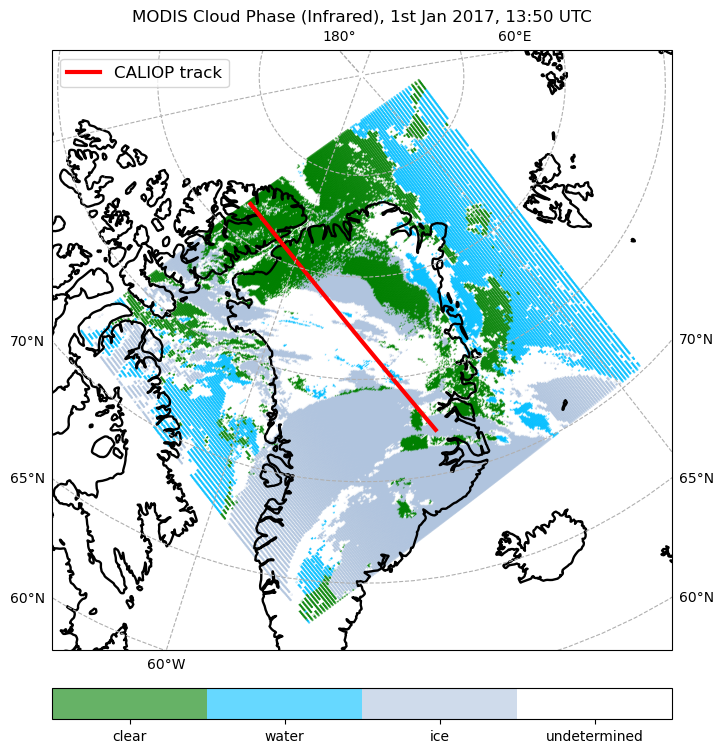

In [4]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from caliop import Caliop_hdf_reader
import pandas as pd
import os
import datetime

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

print(np.size(modis_cloud_phase))

path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"
caliop_data_filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename + ".hdf")

reader_caliop = Caliop_hdf_reader()
caliop_df = pd.DataFrame(columns=["long", "lat", "time", "profile_id"])
caliop_df.long = reader_caliop._get_longitude(caliop_data_filepath)
caliop_df.lat = reader_caliop._get_latitude(caliop_data_filepath)
caliop_df.time = reader_caliop._get_profile_UTC(caliop_data_filepath)
caliop_df.profile_id = reader_caliop._get_profile_id(caliop_data_filepath)
caliop_df = caliop_df.set_index('profile_id')

# eliminate datapoints that are taken at a time later than 2017/01/01 13:53:00 (use datetime object for comparison)
cutoff_time = datetime.datetime(2017, 1, 1, 13, 56, 30)
caliop_df = caliop_df[caliop_df.time < cutoff_time]


def byte_to_label(byte):
    if byte == 6:
        return 4.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

# make the last color transparent (for undetermined pixels)

colormap = ListedColormap(['green', 'deepskyblue', 'lightsteelblue', (1, 1, 1, 0)])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,10), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1.7)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.6)
ax.plot(caliop_df.long, caliop_df.lat, 'r', linewidth=3, transform=ccrs.PlateCarree(), label="CALIOP track")
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 5), pad=0.05)
# make legend bigger
ax.legend(loc="upper left", fontsize="large")
ax.set_title("MODIS Cloud Phase (Infrared), 1st Jan 2017, 13:50 UTC")

cbar.set_ticklabels(['clear','water','ice', 'undetermined'])

# save fig with high dpi
plt.savefig("MODIS_cloud_phase.png", dpi=250, bbox_inches='tight')


## Read MYD06 data and plot cloud fractions

array([[<Axes: title={'center': 'frac'}>]], dtype=object)

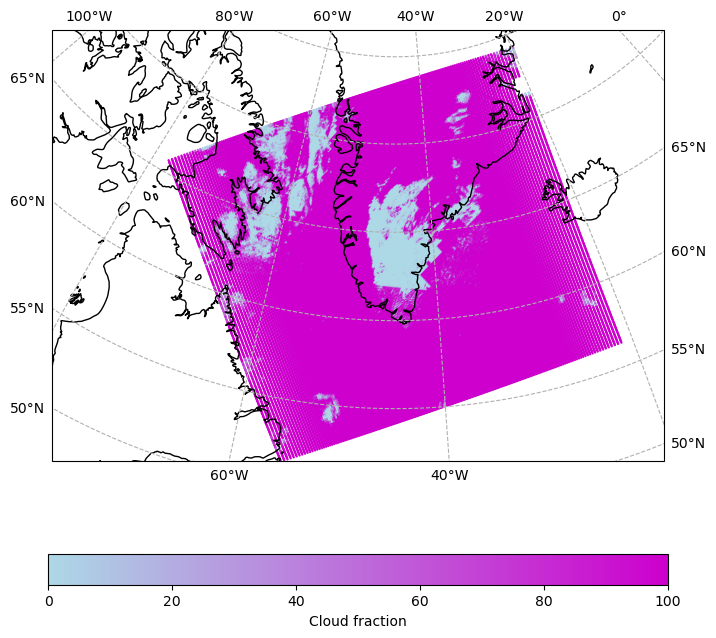

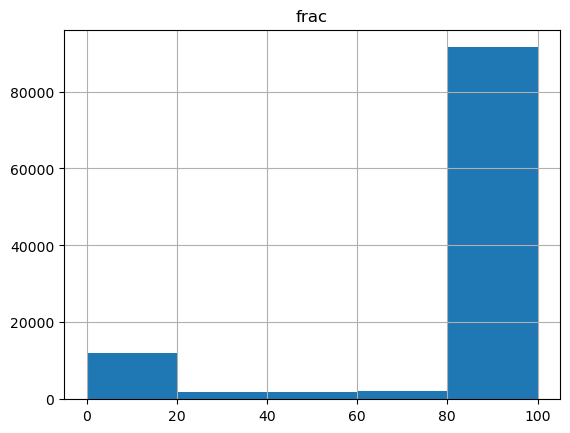

In [133]:
modis_cloud_fraction = MODIS_reader.select("Cloud_Fraction").get()
invalid_data_mask = modis_cloud_fraction > 100

modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_fraction = np.ma.array(modis_cloud_fraction, mask=invalid_data_mask)


def create_skyblue_to_transparent_cmap():
    # Define the colors
    colors = [(173/255, 216/255, 230/255, 1), (205/255, 0/255, 205/255, 1)]

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list("lightblue_to_grey", colors)

    return cmap

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=modis_cloud_fraction, marker='.', s=2, transform=ccrs.PlateCarree(),
                 cmap=create_skyblue_to_transparent_cmap())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", label="Cloud fraction")

import pandas as pd
df = pd.DataFrame(np.array(modis_cloud_fraction).flatten(), columns=["frac"])
df = df[df.frac < 101]
df.hist(bins=5)


## Read MYD06 data and plot cloud mask

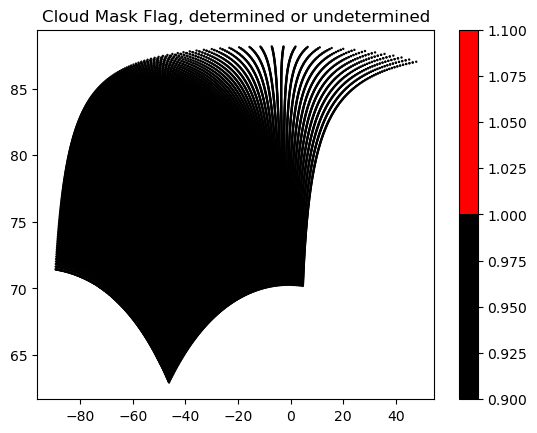

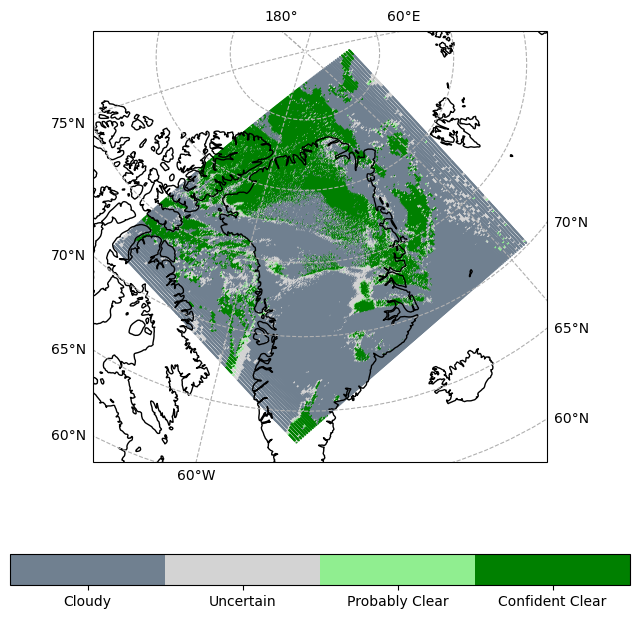

In [174]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_mask_5km = MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0]

# the following section is almost entirely written using ChatGPT

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_5km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

# Map colors to property values
color_mapping = {
    'Cloudy': 0,
    'Uncertain': 1,
    'Probably Clear': 2,
    'Confident Clear': 4
}

# Extract Unobstructed FOV Quality Flag data
quality_flag_data = result['Unobstructed FOV Quality Flag']
color_matrix = np.vectorize(color_mapping.get)(quality_flag_data)
colormap = ListedColormap(['slategrey', 'lightgrey', 'lightgreen', 'green'])

# check if there are undetermined cloud mask pixels
plt.scatter(modis_long, modis_lat, marker='.', s=2, c=np.where(result["Cloud Mask Flag"] == "Determined", 1, 0), cmap=ListedColormap(["black", "red"]))
plt.colorbar()
plt.gca().set_title("Cloud Mask Flag, determined or undetermined")

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
# ccrs_projection = ccrs.NorthPolarStereo()
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent((np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)), ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
pos = ax.scatter(modis_long, modis_lat, c=color_matrix, marker='.', s=2, transform=ccrs.PlateCarree(), cmap=colormap)
cbar = fig.colorbar(pos, ticks=[0.5, 1.5, 2.5, 3.5], location="bottom")
cbar.set_ticklabels(['Cloudy', 'Uncertain', 'Probably Clear', 'Confident Clear'])

# Use collocation database to load CALIOP and MODIS products

## Select date and load collocation csv

In [2]:
import pandas as pd
import os
import datetime

path_to_collocation_database = "./collocation_database/"
selected_date = datetime.datetime(year=2017, month=1, day=1)

def select_CALIOP_file_by_day(path_to_month_folder, day):
    import glob

    search_pattern = f"*-{day:02d}T*"
    return glob.glob(search_pattern, root_dir=path_to_month_folder)

path_to_collocation_month = os.path.join(path_to_collocation_database, selected_date.strftime("%Y/%m"))

selected_CALIOP_file_list = select_CALIOP_file_by_day(path_to_collocation_month, selected_date.day)

collocated_dfs = {}

for file in selected_CALIOP_file_list:
    collocated_dfs[file[0:-4]] = pd.read_csv(os.path.join(path_to_collocation_month, file))
    display(collocated_dfs[file[0:-4]].MODIS_file.describe())

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

count                                              130
unique                                               2
top       MYD35_L2.A2017001.1530.061.2018029020435.hdf
freq                                               124
Name: MODIS_file, dtype: object

count                                              250
unique                                               1
top       MYD35_L2.A2017001.1525.061.2018029020525.hdf
freq                                               250
Name: MODIS_file, dtype: object

count                                              257
unique                                               1
top       MYD35_L2.A2017001.1350.061.2018029021044.hdf
freq                                               257
Name: MODIS_file, dtype: object

## Understand CALIOP layer data

./test_data/CALIOP/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.hdf
(15, 3728)


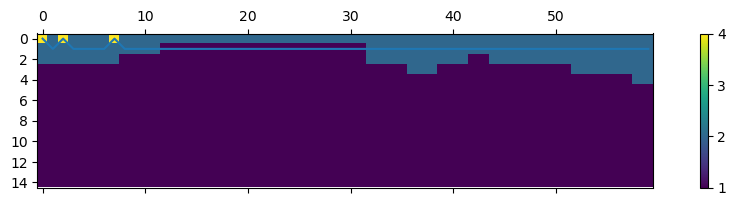

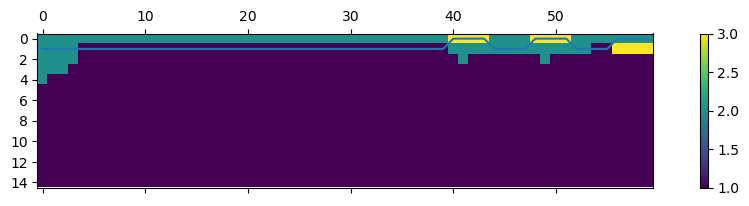

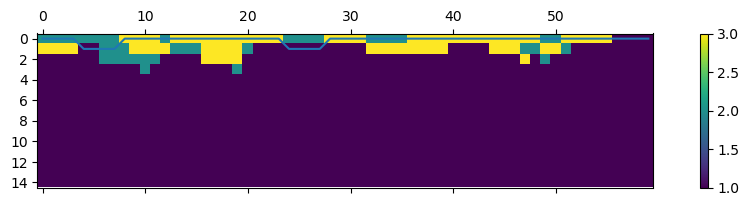

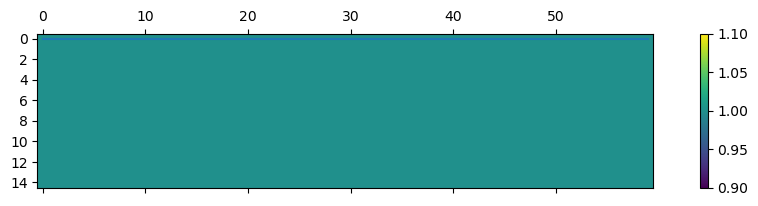

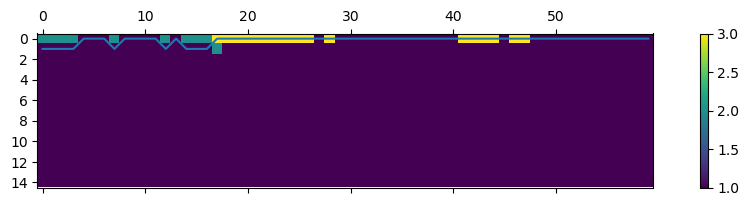

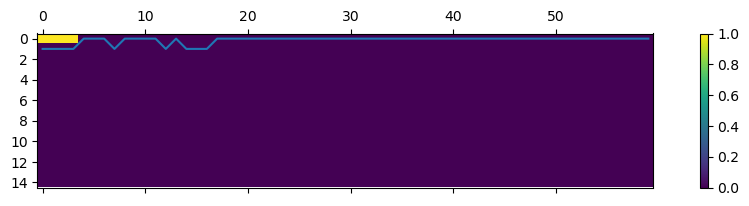

In [80]:
from caliop import Caliop_hdf_reader
import numpy as np
import matplotlib.pyplot as plt

caliop_folder = "./test_data/CALIOP/"
caliop_folder = os.path.join(caliop_folder, selected_date.strftime("%Y/%m"), )

caliop_reader = Caliop_hdf_reader()
# for file in selected_CALIOP_file_list:
filepath = os.path.join(caliop_folder, selected_CALIOP_file_list[3][0:-4] + ".hdf")
print(filepath)

caliop_long, caliop_lat = caliop_reader._get_longitude(filepath), caliop_reader._get_latitude(filepath)

# the first output variable is aerosol type, which I do not need
# feature_classification = caliop_reader._get_calipso_data(filepath, "Layer_Type")
_, feature_classification = caliop_reader._get_feature_classification(filepath, "Feature_Classification_Flags")
cloud_phase, cloud_phase_qa = caliop_reader._get_cloud_phase(filepath, "Feature_Classification_Flags")

print(np.shape(cloud_phase))

cloudy_aerosol_free_profiles_mask = np.where(np.any(feature_classification == 2, axis=0) &\
                                          ~np.any(feature_classification == 3, axis=0) &\
                                            ~np.any(feature_classification == 4, axis=0), True, False)

for i in range(5):
    fig, ax = plt.subplots(figsize=(12,2))
    pos = ax.matshow(feature_classification[:, 60 * i:60 + 60 * i])
    ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
    fig.colorbar(pos)

# i=13
# plt.matshow(feature_classification[:, 60 * i:60 + 60 * i])
# plt.colorbar()
fig, ax = plt.subplots(figsize=(12,2))
pos = ax.matshow(cloud_phase[:, 60 * i:60 + 60 * i])
ax.plot(cloudy_aerosol_free_profiles_mask[60 * i:60 + 60 * i])
fig.colorbar(pos)

## Build CALIOP layer data DataFrame

In [154]:
import pandas as pd
import os
from caliop import Caliop_hdf_reader
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap

path_to_collocation_database = "./collocation_database/"
path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
caliop_data_filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename + ".hdf")

collocation_table = pd.read_csv(collocation_filepath)

def CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath):
    reader_caliop = Caliop_hdf_reader()
    caliop_df = pd.DataFrame(columns=["long", "lat", "time", "profile_id"])
    caliop_df.long = reader_caliop._get_longitude(caliop_data_filepath)
    caliop_df.lat = reader_caliop._get_latitude(caliop_data_filepath)
    caliop_df.time = reader_caliop._get_profile_UTC(caliop_data_filepath)
    caliop_df.profile_id = reader_caliop._get_profile_id(caliop_data_filepath)
    caliop_df = caliop_df.set_index('profile_id')
    _, layer_type = reader_caliop._get_feature_classification(caliop_data_filepath, "Feature_Classification_Flags")
    caliop_df["cloudy"] = np.where(np.any(layer_type == 2, axis=0), True, False)
    # caliop_df["aerosol_free_cloud"] = np.where((~np.any(layer_type == 3, axis=0) &\
    #                                     ~np.any(layer_type == 4, axis=0)) &\
    #                                         np.any(layer_type == 2, axis=0), True, False)
    caliop_df["clear"] = np.where(np.all(layer_type == 1, axis=0), True, False)
    caliop_df["invalid"] = np.where(np.any(layer_type == 0, axis=0), True, False)
    caliop_df["aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
                                        np.any(layer_type == 4, axis=0)), True, False)
    # caliop_df["cloud_free_aerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
    #                                     np.any(layer_type == 4, axis=0)) &\
    #                                         ~np.any(layer_type == 2, axis=0), True, False)

    cloud_phase_layer, cloud_phase_layer_qa = reader_caliop._get_cloud_phase(caliop_data_filepath, "Feature_Classification_Flags")

    caliop_df["water_cloud"] = np.where(np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["ice_cloud"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["mixed_phase"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["unkown_phase"] = np.where(caliop_df["cloudy"] &\
                                        np.any(cloud_phase_layer == 0, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)

    return caliop_df

caliop_df = CALIOP_cloud_phase_to_DataFrame(caliop_data_filepath).loc[collocation_table.profile_id]

display(caliop_df.head())
print("total profiles ", len(caliop_df))
print("all clear ", sum(caliop_df.clear))
print("all invalid ", sum(caliop_df.invalid))
print("aerosol profiles ", sum(caliop_df.aerosol))
# print("cloud free aerosol profiles ", sum(caliop_df.cloud_free_aerosol))
# print("aerosol free cloud profiles ", sum(caliop_df.aerosol_free_cloud))
print("cloudy profiles ", sum(caliop_df.cloudy))
print("of which water clouds", sum(caliop_df.water_cloud))
print("or ice clouds ", sum(caliop_df.ice_cloud))
print("or mixed phase ", sum(caliop_df.mixed_phase))
print("cloudy, unknown phase ", sum(caliop_df.unkown_phase))

long        lat                time  cloudy  clear  invalid  \
profile_id                                                                     
27210      -28.642246  72.176956 2017-01-01 13:52:35    True  False    False   
27225      -28.713709  72.216904 2017-01-01 13:52:35    True  False    False   
27240      -28.785179  72.256775 2017-01-01 13:52:36    True  False    False   
27255      -28.858015  72.296562 2017-01-01 13:52:37    True  False    False   
27270      -28.930428  72.336159 2017-01-01 13:52:38    True  False    False   

            aerosol  water_cloud  ice_cloud  mixed_phase  unkown_phase  
profile_id                                                              
27210          True        False       True        False         False  
27225         False        False       True        False         False  
27240          True        False       True        False         False  
27255         False        False       True        False         False  
27270         False        False       True        False         False

total profiles  257
all clear  72
all invalid  0
aerosol profiles  63
cloudy profiles  160
of which water clouds 38
or ice clouds  89
or mixed phase  15
cloudy, unknown phase  18


## Compare to MODIS cloud-phase classification

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


160


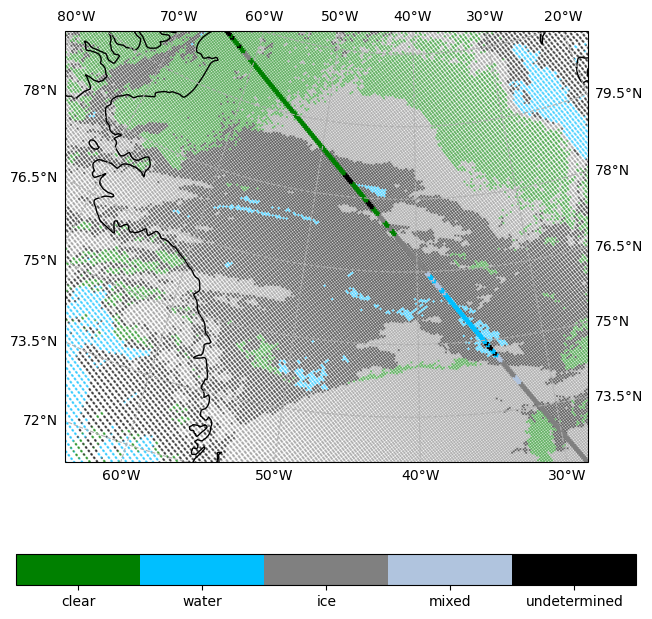

In [155]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()

invalid_data_mask = modis_cloud_phase > 6
modis_long, modis_lat = np.ma.array(modis_long, mask=invalid_data_mask), np.ma.array(modis_lat, mask=invalid_data_mask)
modis_cloud_phase = np.ma.array(modis_cloud_phase, mask=invalid_data_mask)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])
color_array = np.where(caliop_df.water_cloud, 1, 0) + np.where(caliop_df.unkown_phase, 5, 0) +\
                np.where(caliop_df.ice_cloud, 2, 0) + np.where(caliop_df.mixed_phase, 3, 0) + 0.5

print(sum(caliop_df.water_cloud | caliop_df.ice_cloud | caliop_df.mixed_phase | caliop_df.unkown_phase))

ccrs_projection = ccrs.Orthographic(central_longitude=caliop_df.long.median(), central_latitude=caliop_df.lat.median())
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.set_extent([caliop_df.long.min(), caliop_df.long.max(), caliop_df.lat.min(), caliop_df.lat.max()])
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=2, cmap=colormap, transform=ccrs.PlateCarree(), alpha=0.5)
pos = ax.scatter(caliop_df.long, caliop_df.lat, marker='*', s=10, c=color_array, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))
# cbar = fig.colorbar(pos, ax=ax, location="bottom")
cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

fig.savefig("temp.png", dpi=500)

## Only plot collocated MODIS pixels and their phase

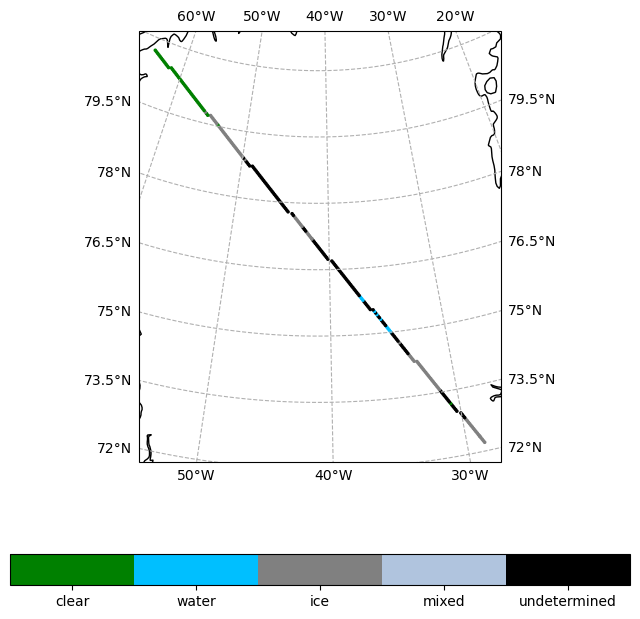

In [6]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

path_to_collocation_database = "./collocation_database/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN"

collocation_filepath = os.path.join(path_to_collocation_database, date_folder, caliop_filename + ".csv")
collocation_table = pd.read_csv(collocation_filepath)

MODIS_filename = "MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
# filename_mask = collocation_table.MODIS_file == MODIS_filename
modis_collocated_indices = collocation_table.modis_idx

MODIS_path = os.path.join("./test_data/MODIS/2017/01/01/", MODIS_filename)

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
modis_cloud_phase = MODIS_reader.select("Cloud_Phase_Infrared").get()


modis_long = np.array(modis_long).flatten()[modis_collocated_indices]
modis_lat = np.array(modis_lat).flatten()[modis_collocated_indices]
modis_cloud_phase = np.array(modis_cloud_phase).flatten()[modis_collocated_indices]

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

def byte_to_label(byte):
    if byte == 6:
        return 5.5
    else:
        return byte + 0.5

labels = [byte_to_label(byte) for byte in np.array(modis_cloud_phase).flatten()]
colormap = ListedColormap(['green', 'deepskyblue', 'grey', 'lightsteelblue', 'black'])

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
pos = ax.scatter(modis_long, modis_lat, c=labels, marker='.', s=10, cmap=colormap, transform=ccrs.PlateCarree(), alpha=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
cbar = fig.colorbar(pos, ax=ax, location="bottom", ticks=np.arange(1, 6))

cbar.set_ticklabels(['clear','water','ice','mixed', 'undetermined'])

# Compile statistics

## What is the Viewing Angle distribution?

### Sensor Zenith Angle is the variable I care about. Read it and plot it

Text(0.5, 1.0, 'Zenith Viewing Angle in MODIS image')

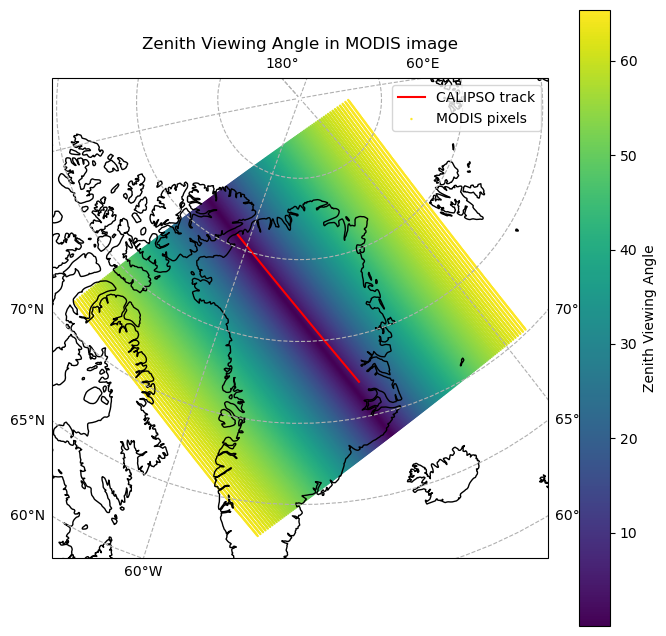

In [4]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
from caliop import Caliop_hdf_reader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1350.061.2018029075638.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"
# MODIS_path = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1530.061.2018029075939.hdf"

collocation_path = "./collocation_database/2017/01/CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.csv"

collocation_table = pd.read_csv(collocation_path)
caliop_long = collocation_table.long.values
caliop_lat = collocation_table.lat.values

MODIS_reader = SD(MODIS_path)
modis_long, modis_lat = MODIS_reader.select("Longitude").get(), MODIS_reader.select("Latitude").get()
sensor_zenith_angle = MODIS_reader.select("Sensor_Zenith").get() / 100

modis_central_long, modis_central_lat = np.median(modis_long), np.median(modis_lat)

ccrs_projection = ccrs.Orthographic(central_longitude=modis_central_long, central_latitude=modis_central_lat)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
# ax.set_extent([np.min(modis_long), np.max(modis_long), np.min(modis_lat), np.max(modis_lat)], ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.plot(caliop_long, caliop_lat, c="red", transform=ccrs.PlateCarree(), label="CALIPSO track")
pos = ax.scatter(modis_long, modis_lat, c=sensor_zenith_angle, marker='.', s=2, transform=ccrs.PlateCarree(), label="MODIS pixels")
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.legend()
cbar = fig.colorbar(pos, label="Zenith Viewing Angle")
ax.set_title("Zenith Viewing Angle in MODIS image")

### Read the collocation database for January of 2017 and produce VZA distribution

252it [00:00, 527.05it/s]


52347


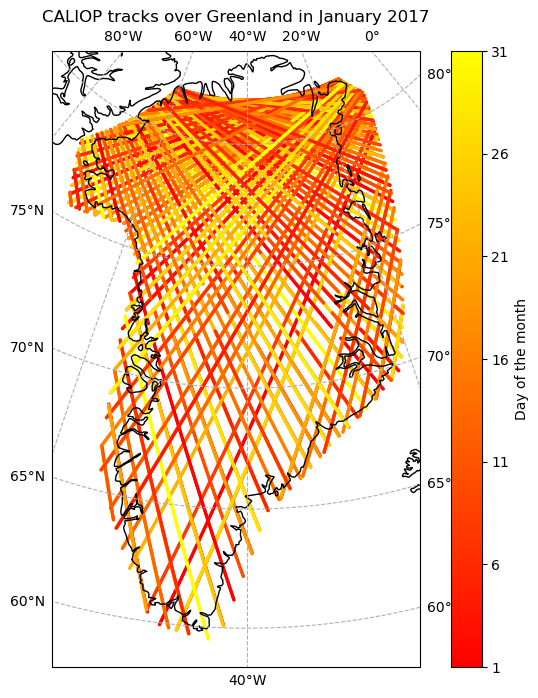

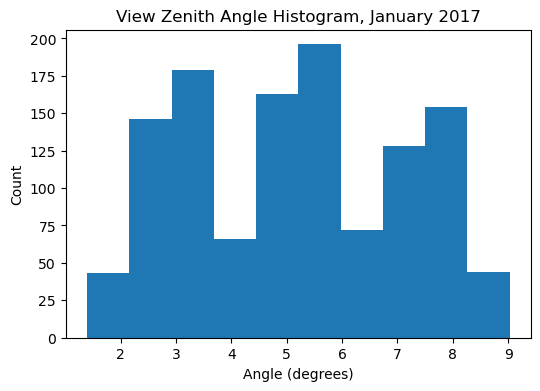

In [16]:
from pyhdf.HDF import *
from pyhdf.SD import *
from pyhdf.V import *
import os
import pandas as pd
import cartopy.crs as ccrs
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import glob

# path_to_2017_collocation_database = \
#     "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/collocation_database/2017/01"
path_to_2017_collocation_database = \
    "/Users/alexandrudobra/University/MPhys/Project/collocation_testing/JASMIN_tests/hospital01/collocation_testing/collocation_database"
path_to_MODIS_folder = "./test_data/MODIS/2017/01/01/"

def get_sensor_zenith_angle(folder, collocation):
    modis_files = collocation.MODIS_file.unique()
    readers = {}
    search_strings = {}
    pixel_angles = np.full(len(collocation.index), -1)

    for modis_file in modis_files:
        search_strings[modis_file] = "*" + modis_file[9:22] + "*"

        myd06_file = glob.glob(search_strings[modis_file], root_dir=folder)
        
        if myd06_file == []:
            continue

        readers[modis_file] = SD(os.path.join(folder, myd06_file[0]))
        view_zenith_angle = np.array(readers[modis_file].select("Sensor_Zenith").get()).flatten()
        pixel_angles[collocation.MODIS_file == modis_file] = view_zenith_angle[collocation[collocation.MODIS_file == modis_file].modis_idx]

    return pixel_angles


collocation_csv_filelist = glob.glob("*.csv", root_dir=path_to_2017_collocation_database)

total_collocated_pixels = 0

ccrs_projection = ccrs.Orthographic(central_longitude=-40, central_latitude=75)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ccrs_projection})
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")

longs, lats = np.empty((0,)), np.empty((0,))
days = np.empty((0,))
pixel_angles = np.zeros((0,))

for file_index, file in tqdm.tqdm(enumerate(collocation_csv_filelist)):
    collocation = pd.read_csv(os.path.join(path_to_2017_collocation_database, file))
    total_collocated_pixels += len(collocation.index)

    pixel_angles = np.concatenate([pixel_angles, (get_sensor_zenith_angle(path_to_MODIS_folder, collocation))])

    days = np.concatenate((days,[date.day for date in pd.to_datetime(collocation.time)]))
    longs = np.concatenate((longs, collocation.long))
    lats = np.concatenate((lats, collocation.lat))

pos = ax.scatter(longs, lats, c=days, s=2, transform=ccrs.PlateCarree(), cmap="autumn")
fig.colorbar(pos, ticks=range(1, 32, 5), label="Day of the month")
ax.set_title("CALIOP tracks over Greenland in January 2017")

print(total_collocated_pixels)

pixel_angles = pixel_angles[pixel_angles != -1] / 100
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(pixel_angles)
ax.set_title("View Zenith Angle Histogram, January 2017")
ax.set_xlabel("Angle (degrees)")
ax.set_ylabel("Count")
fig.savefig("view_zenith_angle_histogram_2017_01.png", dpi=200)

## Produce cloud cover and phase statistics

### Test reading in collocation files

In [216]:
import os
import glob
import numpy as np
import pandas as pd

def get_caliop_id_from_filename(filename):
    return filename[-21:-2]

def merge_collocation_data(folder_path):
    if not os.path.isdir(folder_path):
        raise ValueError("The provided path is not a valid directory.")

    # recursively find all files in this directory that match the pattern \-dd\Tdd\- (to make sure we are not reading other csvs)
    collocation_files = glob.glob("**/*-[0-9][0-9]T[0-9][0-9]-*.csv", root_dir=folder_path, recursive=True)

    dataframes = []

    for file in collocation_files:
        file_path = os.path.join(folder_path, file)
        with open(file_path) as f:
            start_and_end_times = f.readline()
            # make a dictionary so the file number can be replaced with the string
            modis_search_strings = {i: file for (i, file) in enumerate(f.readline().split(' ')[:-1])}
        
        df = pd.read_csv(file_path, header=2).rename(columns={"MODIS_file": "mFileID", "modis_idx": "pixel_id"})
        df.mFileID = np.vectorize(modis_search_strings.get)(df.mFileID.values)
        caliop_id = get_caliop_id_from_filename(os.path.basename(file_path)[:-4])
        df["cFileID"] = [caliop_id] * len(df.profile_id.values)

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

# Example usage:
# folder_path = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/JASMIN_tests/10Jan/collocation_database"

folder_path = "./collocation_database/"

merged_df = merge_collocation_data(folder_path)#.set_index("profile_id")
print(len(merged_df))

display(merged_df.head())

merged_df.to_csv("merged_df_test.csv", index=False)

1130


profile_id  pixel_id        mFileID              cFileID
0       89925     63860  A2017001.0540  2017-01-01T05-38-12
1       89940     64130  A2017001.0540  2017-01-01T05-38-12
2       89955     64400  A2017001.0540  2017-01-01T05-38-12
3       89970     64670  A2017001.0540  2017-01-01T05-38-12
4       89985     64940  A2017001.0540  2017-01-01T05-38-12

### Add CALIOP cloud features to the merged collocation data

In [217]:
import pandas as pd
import glob
import os

def get_caliop_id_from_filename(filename):
    return filename[-21:-2]

def get_caliop_cloud_phase(caliop_filepath):
    from caliop import Caliop_hdf_reader
    reader_caliop = Caliop_hdf_reader()
    caliop_df = pd.DataFrame(columns=["profile_id"])
    caliop_df.profile_id = reader_caliop._get_profile_id(caliop_filepath)
    caliop_df = caliop_df.set_index('profile_id')

    _, layer_type = reader_caliop._get_feature_classification(caliop_filepath, "Feature_Classification_Flags")
    caliop_df["cCloudy"] = np.where(np.any(layer_type == 2, axis=0), True, False)
    caliop_df["cClear"] = np.where(np.all(layer_type == 1, axis=0), True, False)
    caliop_df["cInvalid"] = np.where(np.any(layer_type == 0, axis=0), True, False)
    caliop_df["cAerosol"] = np.where((np.any(layer_type == 3, axis=0) |\
                                        np.any(layer_type == 4, axis=0)), True, False)

    cloud_phase_layer, cloud_phase_layer_qa = reader_caliop._get_cloud_phase(caliop_filepath, "Feature_Classification_Flags")

    caliop_df["cWater"] = np.where(np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["cIce"] = np.where((np.any(cloud_phase_layer == 1, axis=0) |\
                                        np.any(cloud_phase_layer == 3, axis=0)) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0), True, False)
    caliop_df["cUnknown"] = np.where(caliop_df["cCloudy"] &\
                                        np.any(cloud_phase_layer == 0, axis=0) &\
                                        ~np.any(cloud_phase_layer == 1, axis=0) &\
                                        ~np.any(cloud_phase_layer == 2, axis=0) &\
                                        ~np.any(cloud_phase_layer == 3, axis=0), True, False)
    caliop_df["cPhaseHighQA"] = np.where(np.any(cloud_phase_layer_qa == 3, axis=0), True, False)

    return caliop_df

caliop_data_folder = "./test_data/CALIOP"
caliop_product = "MLay"
merged_collocation = pd.read_csv("./merged_df_test.csv")

collocated_cloud_phase_dataframes = []

for caliop_file_id in merged_collocation.cFileID.unique():
    caliop_filepath = glob.glob(f"**/*{caliop_product}*{caliop_file_id}*", root_dir=caliop_data_folder, recursive=True)

    if len(caliop_filepath) == 0:
        print(caliop_file_id, "file not found")
        raise Exception

    caliop_filepath = os.path.join(caliop_data_folder, caliop_filepath[0])
    df = get_caliop_cloud_phase(caliop_filepath)

    # reduce to collocated profiles
    df = df.loc[merged_collocation.profile_id[merged_collocation.cFileID == caliop_file_id], :]

    # add the caliop file id to uniquely identify each profile
    df["cFileID"] = [caliop_file_id] * len(df)

    df.reset_index()
    df.set_index(["cFileID"], append=True, inplace=True)

    collocated_cloud_phase_dataframes.append(df)

merged_collocated_caliop_cloud_phase_df = pd.concat(collocated_cloud_phase_dataframes)
print(len(merged_collocated_caliop_cloud_phase_df))
merged_collocated_caliop_cloud_phase_df.head()


1130


cCloudy  cClear  cInvalid  cAerosol  cWater  \
profile_id cFileID                                                            
89925      2017-01-01T05-38-12    False   False     False      True   False   
89940      2017-01-01T05-38-12    False   False     False      True   False   
89955      2017-01-01T05-38-12    False    True     False     False   False   
89970      2017-01-01T05-38-12    False    True     False     False   False   
89985      2017-01-01T05-38-12    False    True     False     False   False   

                                 cIce  cUnknown  cPhaseHighQA  
profile_id cFileID                                             
89925      2017-01-01T05-38-12  False     False         False  
89940      2017-01-01T05-38-12  False     False         False  
89955      2017-01-01T05-38-12  False     False         False  
89970      2017-01-01T05-38-12  False     False         False  
89985      2017-01-01T05-38-12  False     False         False

In [203]:
merged_collocated_caliop_cloud_phase_df.index.get_level_values(1).unique()

Index(['2017-01-01T05-38-12', '-01T15-31-33ZN_Subs', '-01T14-38-58ZD_Subs',
       '2017-01-01T13-52-38'],
      dtype='object', name='cFileID')

### Add MODIS features to the merged collocation

#### Where is the phase information?
The best phase data is found in `Cloud_Phase_Infrared_1km` and `Cloud_Phase_Optical_Properties` (for daytime pixels only). Both are 1km so they will have to be downsampled.

(2030, 1354)


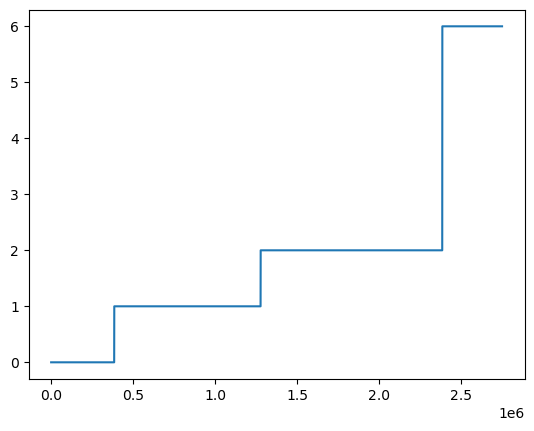

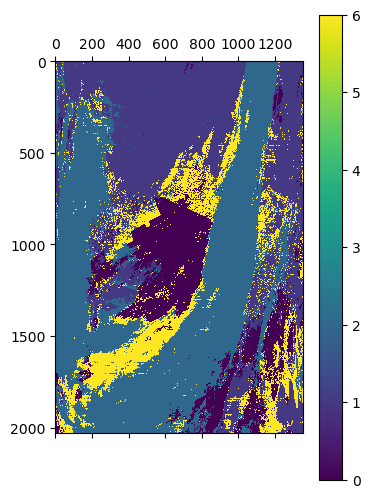

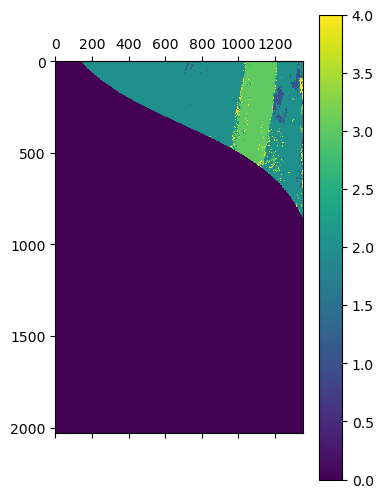

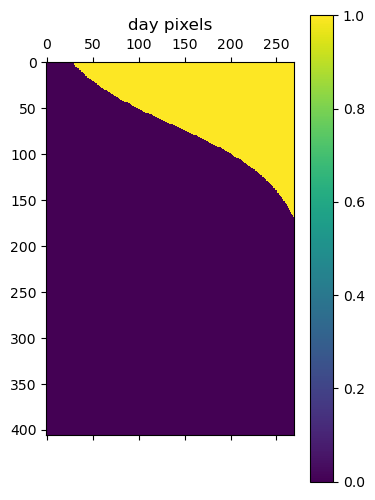

In [78]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)
modis_cloud_mask_1km = MODIS_reader.select("Cloud_Mask_1km").get()[:,:,0]

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 'Yes', 'No')

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 'Water',
        0b01: 'Coastal',
        0b10: 'Desert',
        0b11: 'Land'
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_1km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

solar_zenith = MODIS_reader.select("Solar_Zenith").get()
daytime_pixels = solar_zenith < 8136

modis_infrared_phase = MODIS_reader.select("Cloud_Phase_Infrared_1km").get()
modis_optical_phase = MODIS_reader.select("Cloud_Phase_Optical_Properties").get()

infrared_fillvalue = MODIS_reader.select("Cloud_Phase_Infrared_1km").attributes().get("_FillValue")
optical_fillvalue = MODIS_reader.select("Cloud_Phase_Optical_Properties").attributes().get("_FillValue")

modis_infrared_phase = np.where(modis_infrared_phase == infrared_fillvalue, 6, modis_infrared_phase)

plt.plot(np.sort(modis_infrared_phase.flatten()))
plt.matshow(modis_infrared_phase)
plt.colorbar()
plt.matshow(modis_optical_phase)
plt.colorbar()
plt.matshow(daytime_pixels)
plt.gca().set_title("day pixels")
plt.colorbar()

print(modis_infrared_phase.shape)


#### Compare the 1km IR cloud-phase product to the version downsampled to 5km and to the 5km IR cloud-phase product

The downsampled version is better.

(406, 270)


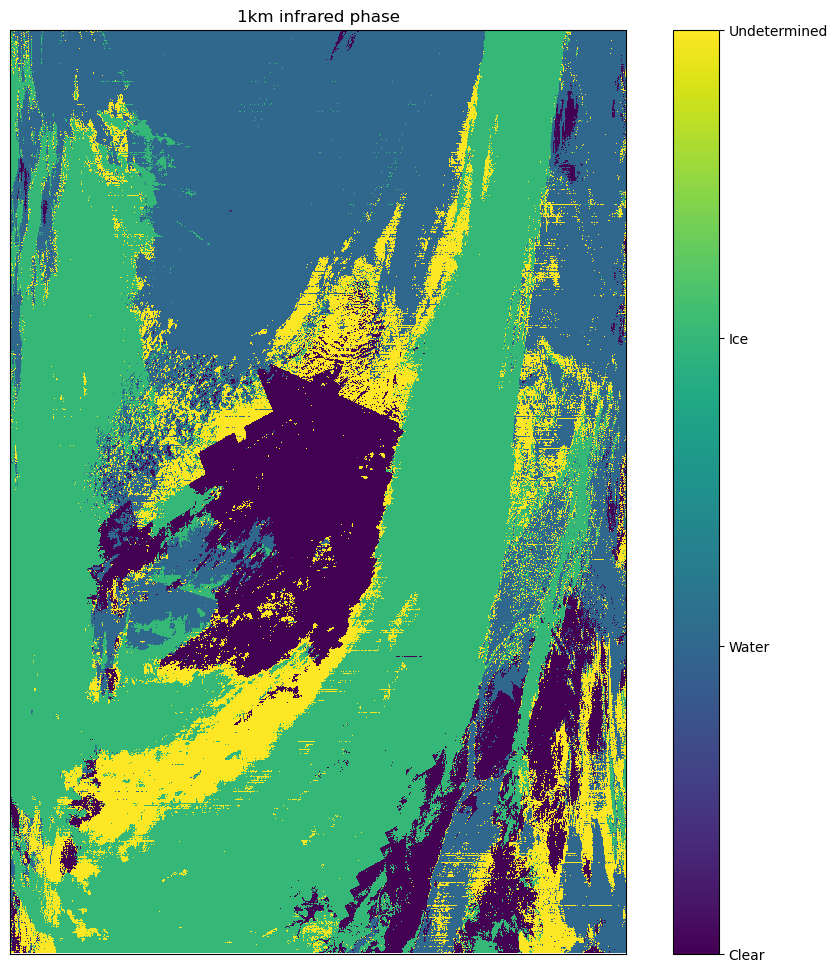

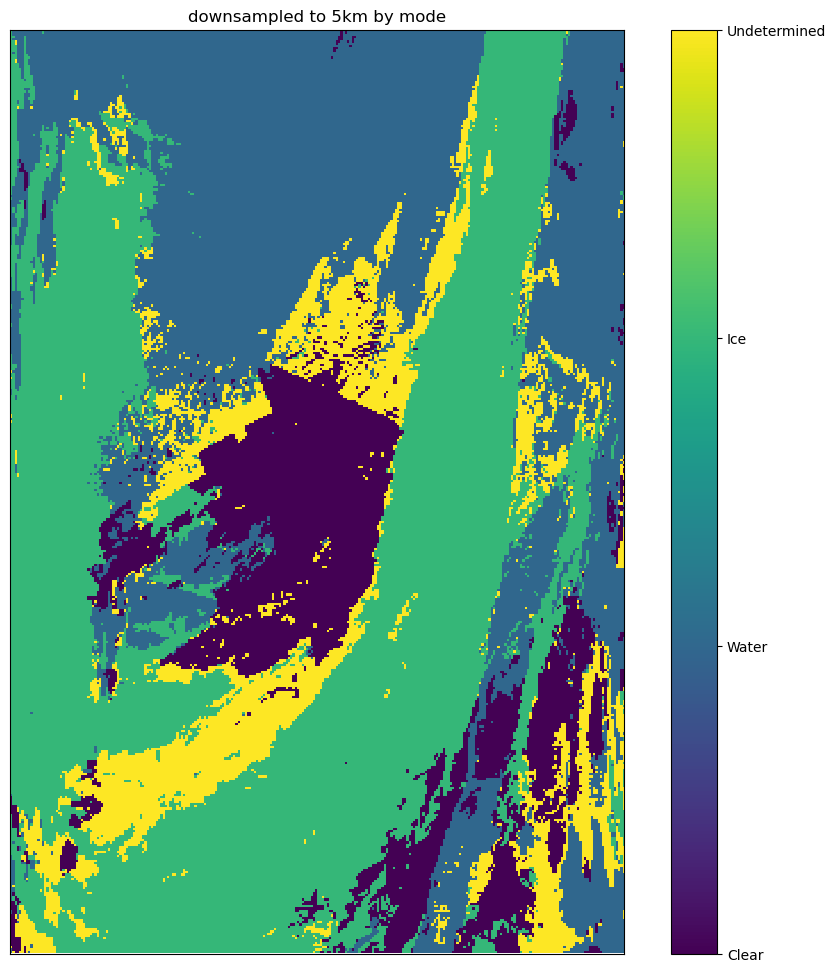

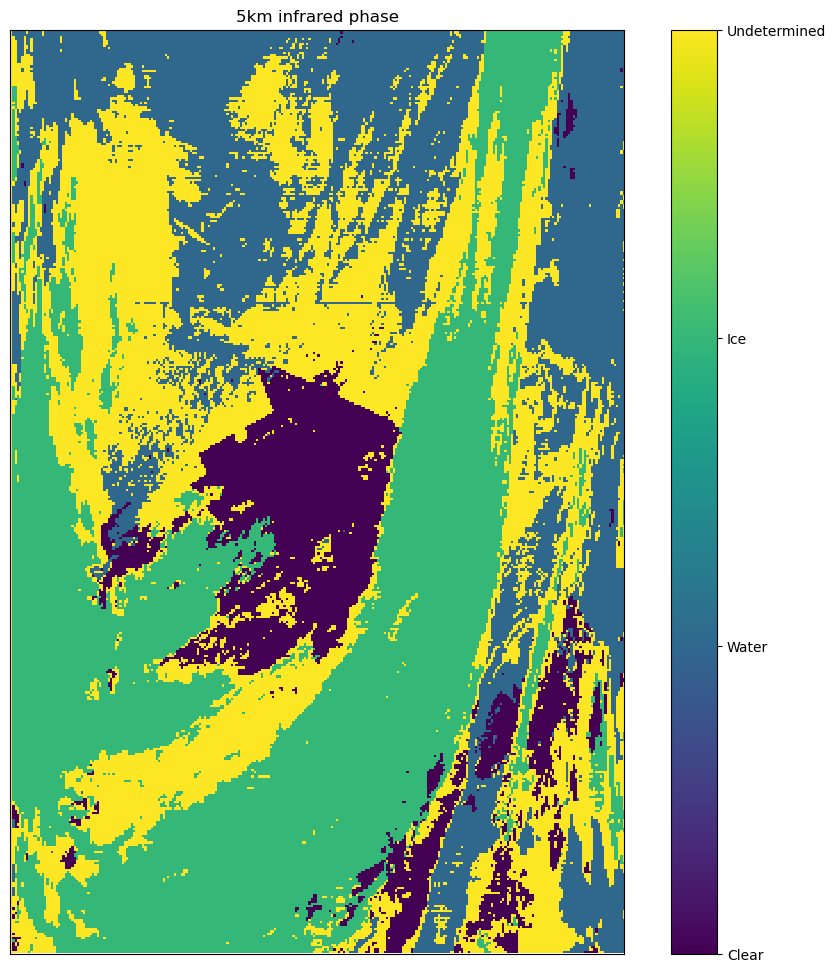

In [79]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def downsample_2d_array_vectorized(input_array, fill_value):
    # Convert the input array to a NumPy array
    input_np = np.array(input_array)
    
    # Get the dimensions of the input array
    rows, cols = input_np.shape
    
    from math import floor

    # Check if the array dimensions are divisible by 5
    rows, cols = floor(rows/5) * 5, floor(cols/5) * 5
    input_np = input_np[:rows, :cols]
    
    # Reshape the input array into 5x5 chunks
    reshaped_array = input_np.reshape(rows//5, 5, cols//5, 5).transpose((0, 2, 1, 3)).reshape(rows//5, cols//5, 25)
    
    # Check if each 5x5 chunk has the same value
    repeated_tiles = np.tile(reshaped_array[:,:,0][:,:,np.newaxis], 25)
    unique_values = np.all(reshaped_array == repeated_tiles, axis=2)
    
    # Create the output array with the appropriate fill values
    output_array = np.where(unique_values, reshaped_array[:, :, 0], fill_value)
    
    return output_array

def downsample_array_voting(input_array, fillvalue, pixelXsize=5, pixelYsize=5, threshold=20):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # Reshape the input array into 5x5 chunks
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    def find_element_above_threshold(arr, threshold, fillvalue):
        unique_elements, element_counts = np.unique(arr, return_counts=True)
        above_threshold_indices = np.nonzero(element_counts >= threshold)[0]

        if above_threshold_indices.size > 0:
            return unique_elements[above_threshold_indices[0]]
        else:
            return fillvalue
    
    output_array = np.apply_along_axis(lambda x: find_element_above_threshold(x, threshold, fillvalue), axis=2, arr=reshaped_array)

    return output_array

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)

modis_infrared_phase_5km = MODIS_reader.select("Cloud_Phase_Infrared").get()
modis_infrared_phase_5km = np.where(modis_infrared_phase_5km == 127, 3, 
modis_infrared_phase_5km)
modis_infrared_phase_5km = np.where(modis_infrared_phase_5km == 6, 3, modis_infrared_phase_5km)

modis_infrared_phase = MODIS_reader.select("Cloud_Phase_Infrared_1km").get()
modis_infrared_phase = np.where(modis_infrared_phase == 127, 3, modis_infrared_phase)
modis_infrared_phase = np.where(modis_infrared_phase == 6, 3, modis_infrared_phase)

downsampled_test = downsample_array_by_mode(modis_infrared_phase)

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(modis_infrared_phase)
ax.set_title("1km infrared phase")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(downsampled_test)
ax.set_title("downsampled to 5km by mode")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(modis_infrared_phase_5km)
ax.set_title("5km infrared phase")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Clear', 'Water', 'Ice', 'Undetermined'])

print(downsampled_test.shape)

#### Compare the 1km cloud-mask product to the version downsampled to 5km and to the 5km cloud-mask product

The 5km version is better than the downsampled one. This means improvements can be made to the downsampling algorithm.

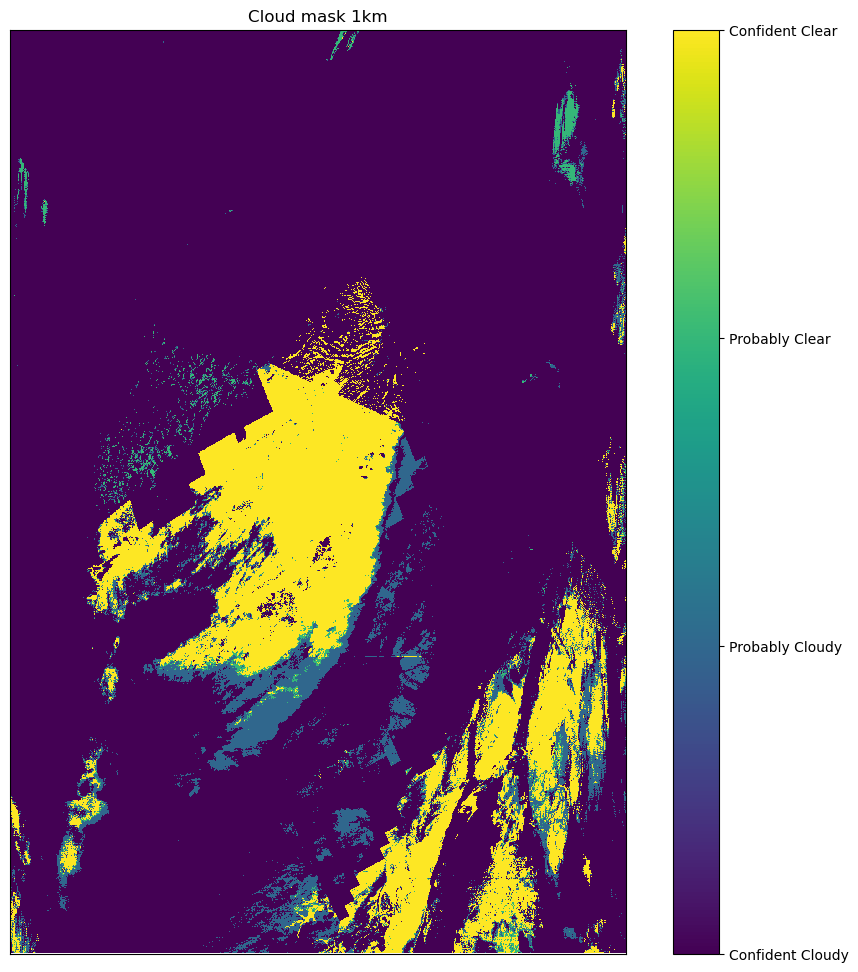

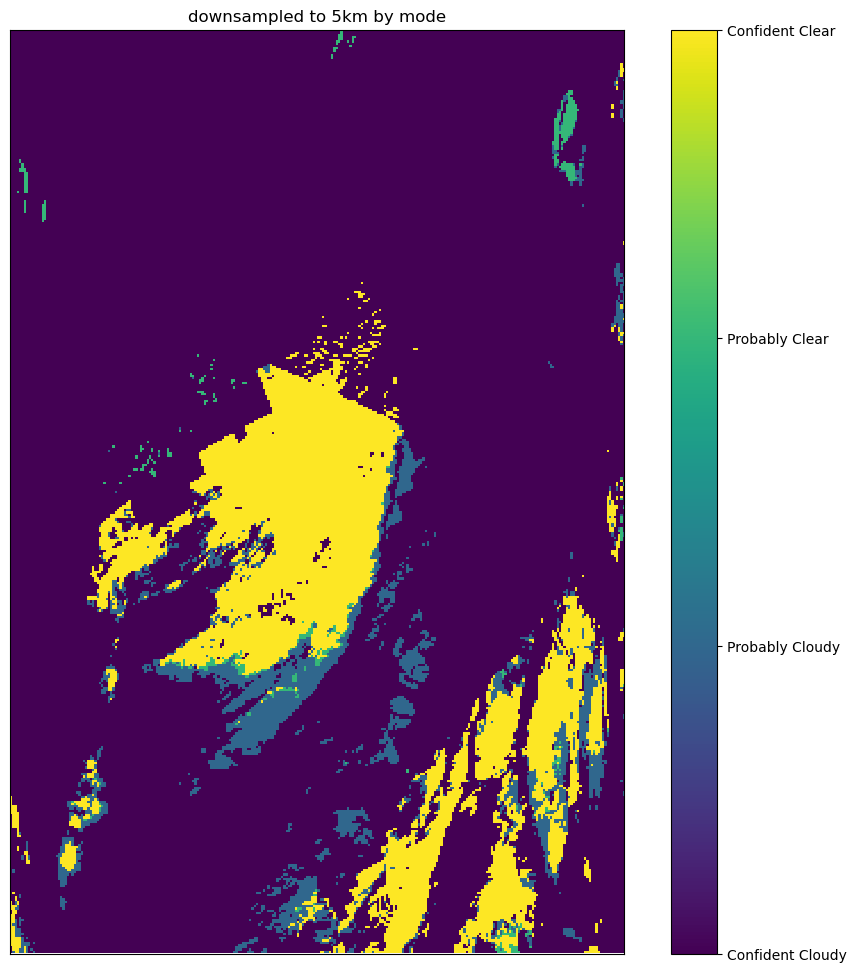

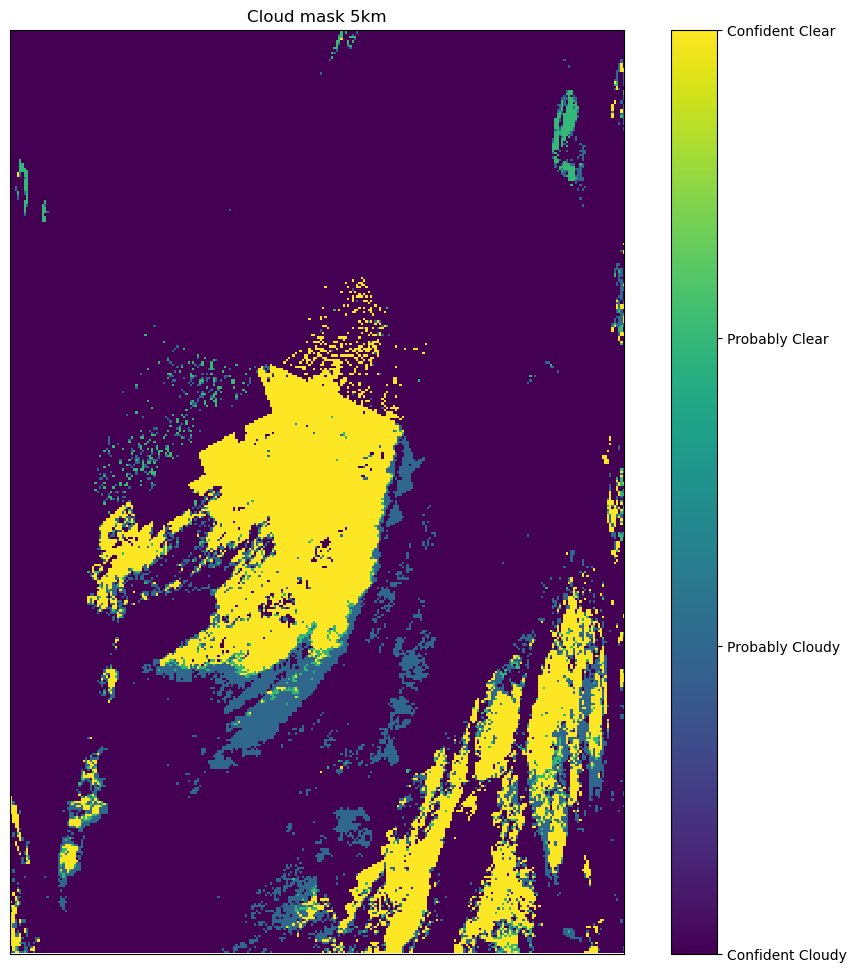

In [148]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

def get_cloudiness_flag(byte_array):
    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 0,
        0b01: 1,
        0b10: 2,
        0b11: 3
    }

    return np.vectorize(quality_mapping.get)(quality_flag)

modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# def get_modis_cloud_phase_to_df(modis_filepath):
MODIS_reader = SD(modis_filepath)

cloud_mask_5km = get_cloudiness_flag(MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0])

cloud_mask_1km = get_cloudiness_flag(MODIS_reader.select("Cloud_Mask_1km").get()[:,:,0])

downsampled_test = downsample_array_by_mode(cloud_mask_1km)

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(cloud_mask_1km)
ax.set_title("Cloud mask 1km")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(downsampled_test)
ax.set_title("downsampled to 5km by mode")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])

fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(cloud_mask_5km)
ax.set_title("Cloud mask 5km")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Confident Cloudy', 'Probably Cloudy', 'Probably Clear', 'Confident Clear'])


#### Get MODIS cloud information into a dataframe

In [214]:
from pyhdf.SD import *
import pandas as pd
import glob
import os

def downsample_array_by_mode(input_array, pixelXsize=5, pixelYsize=5):
    input_array = np.array(input_array)
    rows, cols = input_array.shape
    
    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_array = input_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = input_array.reshape(rows, pixelXsize, cols, pixelYsize).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # output_array = scipy.stats.mode(reshaped_array, axis=2, keepdims=True)[0]
    output_array = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=2, arr=reshaped_array)

    return output_array

def get_modis_5km_cloud_phase(modis_filepath, daytime_only=False):
    if not os.path.exists(modis_filepath):
        print("The given MODIS file does not exist.")
        return

    df = pd.DataFrame(columns=["pixel_id", "mCloudy", "mClear", "mWater", "mIce", "mUndetermined"])

    reader = SD(modis_filepath)
    if not daytime_only:
        phase_1km  = reader.select("Cloud_Phase_Infrared_1km").get()
        fill_value = reader.select("Cloud_Phase_Infrared_1km").attributes().get("_FillValue")
        phase_1km = np.where((phase_1km == fill_value) | (phase_1km == 6), 3, phase_1km)
    else:
        phase_1km  = reader.select("Cloud_Phase_Optical_Properties").get()
        fill_value = reader.select("Cloud_Phase_Optical_Properties").attributes().get("_FillValue")
        phase_1km = np.where(phase_1km == fill_value, 5, phase_1km)
        phase_1km -= 1

    phase_downsampled = downsample_array_by_mode(phase_1km, pixelXsize=5, pixelYsize=5).flatten()

    df["pixel_id"] = np.arange(len(phase_downsampled))
    df.set_index("pixel_id", inplace=True)
    df["mClear"] = phase_downsampled == 0
    df["mWater"] = phase_downsampled == 1
    df["mIce"] = phase_downsampled == 2
    df["mUndetermined"] = phase_downsampled == 3
    # df["mInfraredAlg"] = [True] * len(df)

    if daytime_only:
        df = df[phase_downsampled != 4]
        # df["mInfraredAlg"] = [False] * len(df)

    # should I set the cloudy flags according to the mask or according to the phase product?
    # cloud_mask_quality_flag = (MODIS_reader.select("Cloud_Mask_5km").get()[:,:,0] >> 1) & 0b11
    # df["mCloudy"] = (np.array(cloud_mask_quality_flag).flatten() == 0) | (np.array(cloud_mask_quality_flag).flatten() == 1)

    df["mCloudy"] = df["mWater"] | df["mIce"] | df["mUndetermined"]

    return df

modis_data_folder = "./test_data/MODIS"
modis_product = "MYD06"
merged_collocation = pd.read_csv("./merged_df_test.csv")

collocated_cloud_phase_dataframes = []

for modis_file_id in merged_collocation.mFileID.unique():
    modis_filepath = glob.glob(f"**/*{modis_product}*{modis_file_id}*", root_dir=modis_data_folder, recursive=True)

    if len(modis_filepath) == 0:
        print(modis_file_id, "file not found")
        raise Exception

    modis_filepath = os.path.join(modis_data_folder, modis_filepath[0])
    df = get_modis_5km_cloud_phase(modis_filepath)

    if df.empty:
        continue

    # reduce to collocated pixels
    collocated_pixel_ids_in_file = merged_collocation.pixel_id[merged_collocation.mFileID == modis_file_id]
    df = df.loc[np.intersect1d(collocated_pixel_ids_in_file.values, df.index.values), :]

    # add the modis file id to uniquely identify each pixel
    df["mFileID"] = [modis_file_id] * len(df)

    df.reset_index()
    df.set_index(["mFileID"], append=True, inplace=True)

    collocated_cloud_phase_dataframes.append(df)

modis_cloud_df = pd.concat(collocated_cloud_phase_dataframes)

print(len(modis_cloud_df))

modis_cloud_df.head()

# modis_filepath = "./test_data/MODIS/2017/01/01/MYD06_L2.A2017001.1525.061.2018029080401.hdf"

# df = get_modis_5km_cloud_phase_to_df(modis_filepath, daytime_only=True)

display(modis_cloud_df.head(20))
print("total pixels", len(modis_cloud_df))
print("cloudy pixels", sum(modis_cloud_df.mCloudy))
print("clear sky", sum(modis_cloud_df.mClear))
print("water cloud", sum(modis_cloud_df.mWater))
print("ice cloud", sum(modis_cloud_df.mIce))
print("undetermined phase", sum(modis_cloud_df.mUndetermined))
print("water + ice + undetermined", sum(modis_cloud_df.mWater) + sum(modis_cloud_df.mIce) + sum(modis_cloud_df.mUndetermined))

# plt.plot(np.sort(df.index.values))

1120


mCloudy  mClear  mWater   mIce  mUndetermined
pixel_id mFileID                                                     
63860    A2017001.0540    False    True   False  False          False
64130    A2017001.0540    False    True   False  False          False
64400    A2017001.0540    False    True   False  False          False
64670    A2017001.0540    False    True   False  False          False
64940    A2017001.0540    False    True   False  False          False
65210    A2017001.0540    False    True   False  False          False
65480    A2017001.0540    False    True   False  False          False
65750    A2017001.0540    False    True   False  False          False
66020    A2017001.0540    False    True   False  False          False
66290    A2017001.0540    False    True   False  False          False
66560    A2017001.0540    False    True   False  False          False
66830    A2017001.0540    False    True   False  False          False
67100    A2017001.0540    False    True   False  False          False
67370    A2017001.0540    False    True   False  False          False
67640    A2017001.0540    False    True   False  False          False
67910    A2017001.0540    False    True   False  False          False
68180    A2017001.0540     True   False   False  False           True
68450    A2017001.0540     True   False   False  False           True
68720    A2017001.0540     True   False   False  False           True
68990    A2017001.0540    False    True   False  False          False

total pixels 1120
cloudy pixels 824
clear sky 296
water cloud 18
ice cloud 582
undetermined phase 224
water + ice + undetermined 824


### Function that extracts sets of features given the merged collocation dataset

In [227]:
from pyhdf.SD import *
import pandas as pd
import glob
import os

def get_modis_5km_optical_cloud_phase(modis_filepath):
    return get_modis_5km_cloud_phase(modis_filepath, daytime_only=True)

def get_feature_sets(feature_set, data_folder, collocated_file_ids, collocated_profile_ids):
    # parameter validation
    existing_feature_sets = ["modis_infrared_cloud_phase", "modis_optical_cloud_phase", "caliop_cloud_phase"]
    existing_feature_set_extractor_functions = [get_modis_5km_cloud_phase, get_modis_5km_optical_cloud_phase, get_caliop_cloud_phase]
    corresponding_product_names = ["MYD06", "MYD06", "CAL_LID_L2_05kmMLay-Standard-V4-51"]

    feature_set_extractor_func_dict = dict(zip(existing_feature_sets, existing_feature_set_extractor_functions))
    product_name_dict = dict(zip(existing_feature_sets, corresponding_product_names))

    if feature_set not in existing_feature_sets:
        print(f"{feature_set} not in the existing feature set extractor functions. The parameter feature_set should be one of the following:")
        print(", ".join(existing_feature_sets))
        return

    if not os.path.exists(data_folder):
        print(f"The data folder given does not exist.")
        return
    
    collocated_data_df_list = []

    # loop over unique file ids
    for file_id in set(collocated_file_ids):
        file_path = glob.glob(f"**/*{product_name_dict[feature_set]}*{file_id}*", root_dir=data_folder, recursive=True)

        if len(file_path) == 0:
            print(file_id, "file not found")
            raise Exception
        
        file_path = os.path.join(data_folder, file_path[0])
        
        # call the desired function
        df = feature_set_extractor_func_dict[feature_set](file_path)

        if df.empty:
            continue

        # reduce to collocated pixels
        collocated_profile_ids_in_file = collocated_profile_ids[collocated_file_ids == file_id]
        df = df.loc[np.intersect1d(collocated_profile_ids_in_file, df.index.values), :]

        # add the file id to uniquely identify each profile
        df["fileID"] = [file_id] * len(df)

        df.reset_index()
        df.set_index(["fileID"], append=True, inplace=True)

        collocated_data_df_list.append(df)

    return pd.concat(collocated_data_df_list)

test_no = 3
merged_collocation = pd.read_csv("./merged_df_test.csv")

feature_sets = ["modis_infrared_cloud_phase", "modis_optical_cloud_phase", "caliop_cloud_phase", "caliop_cloud_phase"]
data_folders = ["./test_data/MODIS", "./test_data/MODIS", "./test_data/CALIOP", "./test_data/MOI"]
fileID_keys = ["mFileID", "mFileID", "cFileID", "cFileID"]
profileID_keys = ["pixel_id", "pixel_id", "profile_id", "profile_id"]

collocated_file_ids = merged_collocation[fileID_keys[test_no]]
collocated_profile_ids = merged_collocation[profileID_keys[test_no]]

df = get_feature_sets(feature_sets[test_no], data_folders[test_no], collocated_file_ids, collocated_profile_ids)
print(len(df))
df.head(20)


The data folder given does not exist.


TypeError: object of type 'NoneType' has no len()

### Extract cloud-phase information from both satellites and compare

#### Read in features and attach to collocation database

In [46]:
import os
import numpy as np
import pandas as pd
from get_feature_sets import get_feature_sets

# small test
# collocation_database = pd.read_csv("./merged_df_test.csv")
# modis_infrared_phase = get_feature_sets("modis_infrared_cloud_phase", "./test_data/MODIS/", "./merged_df_test.csv")
# caliop_phase = get_feature_sets("caliop_cloud_phase", "./test_data/CALIOP/", "./merged_df_test.csv")

# feb17 test
collocation_database = pd.read_csv("/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/JASMIN_tests/10Jan/collocation_database/merged_collocations.csv")
modis_infrared_phase = pd.read_csv("/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/feb17_modis_infrared_phase_2.csv")
caliop_phase = pd.read_csv("/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/feb17_caliop_phase.csv")

display(collocation_database.head())
display(modis_infrared_phase.head())
display(caliop_phase.head())

# combine collocation_database with modis_infrared_phase by matching the pixel_id and mFileID columns with pixel_id and fileID columns
merged_df = pd.merge(collocation_database, modis_infrared_phase, how="left", left_on=["pixel_id", "mFileID"], right_on=["pixel_id", "fileID"])

# combine merged_df with caliop_phase by matching the profile_id and cFileID columns with profile_id and fileID columns
merged_df = pd.merge(merged_df, caliop_phase, how="left", left_on=["profile_id", "cFileID"], right_on=["profile_id", "fileID"])
display(merged_df.head())


profile_id  pixel_id        mFileID              cFileID
0       35520     60345  A2017059.0755  2017-02-28T07-59-13
1       35535     60615  A2017059.0755  2017-02-28T07-59-13
2       35550     60885  A2017059.0755  2017-02-28T07-59-13
3       35565     61155  A2017059.0755  2017-02-28T07-59-13
4       35580     61425  A2017059.0755  2017-02-28T07-59-13

pixel_id         fileID  mCloudy  mClear  mWater  mIce  mUndetermined  \
0       133  A2017054.1235        1       0       0     0              1   
1     66288  A2017048.0635        1       0       0     0              1   
2     66558  A2017048.0635        1       0       0     0              1   
3     67098  A2017048.0635        1       0       0     0              1   
4     67368  A2017048.0635        1       0       0     0              1   

   mDayPixel  
0          0  
1          0  
2          0  
3          0  
4          0

profile_id               fileID  cCloudy  cClear  cInvalid  cAerosolFree  \
0       47820  2017-02-01T06-36-02        1       0         0             1   
1       47835  2017-02-01T06-36-02        1       0         0             1   
2       47850  2017-02-01T06-36-02        1       0         0             1   
3       47865  2017-02-01T06-36-02        1       0         0             1   
4       47880  2017-02-01T06-36-02        1       0         0             1   

   cWater  cIce  cUnknown  cPhaseHighQA  
0       0     0         0             1  
1       0     0         0             1  
2       0     0         0             1  
3       0     0         0             1  
4       0     0         0             1

profile_id  pixel_id        mFileID              cFileID       fileID_x  \
0       35520     60345  A2017059.0755  2017-02-28T07-59-13  A2017059.0755   
1       35535     60615  A2017059.0755  2017-02-28T07-59-13  A2017059.0755   
2       35550     60885  A2017059.0755  2017-02-28T07-59-13  A2017059.0755   
3       35565     61155  A2017059.0755  2017-02-28T07-59-13  A2017059.0755   
4       35580     61425  A2017059.0755  2017-02-28T07-59-13  A2017059.0755   

   mCloudy  mClear  mWater  mIce  mUndetermined  mDayPixel  \
0        1       0       0     1              0          0   
1        1       0       0     1              0          0   
2        1       0       0     1              0          0   
3        1       0       0     1              0          0   
4        1       0       0     1              0          0   

              fileID_y  cCloudy  cClear  cInvalid  cAerosolFree  cWater  cIce  \
0  2017-02-28T07-59-13        1       0         0             1       0     1   
1  2017-02-28T07-59-13        1       0         0             1       0     1   
2  2017-02-28T07-59-13        1       0         0             1       0     0   
3  2017-02-28T07-59-13        1       0         0             1       0     0   
4  2017-02-28T07-59-13        1       0         0             1       0     0   

   cUnknown  cPhaseHighQA  
0         0             1  
1         0             1  
2         0             1  
3         0             1  
4         0             1

#### Print some stats

In [47]:
print("total profiles", len(caliop_phase))

# save the values in variables
caliop_cloudy_modis_cloudy = sum(merged_df.cCloudy.values & merged_df.mCloudy.values) / sum(merged_df.cCloudy.values)
caliop_cloudy_modis_clear = sum(merged_df.cCloudy.values & merged_df.mClear.values) / sum(merged_df.cCloudy.values)
caliop_clear_modis_cloudy = sum(merged_df.cClear.values & merged_df.mCloudy.values) / sum(merged_df.cClear.values)
caliop_clear_modis_clear = sum(merged_df.cClear.values & merged_df.mClear.values) / sum(merged_df.cClear.values)

# print the values
print("CALIOP cloudy MODIS cloudy", caliop_cloudy_modis_cloudy)
print("CALIOP cloudy MODIS clear", caliop_cloudy_modis_clear)

# Print the sum of the values for the caliop_cloudy variables
total_sum = caliop_cloudy_modis_cloudy + caliop_cloudy_modis_clear
print("Sum of values:", total_sum)

print("CALIOP clear MODIS cloudy", caliop_clear_modis_cloudy)
print("CALIOP clear MODIS clear", caliop_clear_modis_clear)

# Print the sum of the values for the caliop_clear variables
total_sum = caliop_clear_modis_cloudy + caliop_clear_modis_clear
print("Sum of values:", total_sum)

# save the values in variables
caliop_water_modis_water = sum(merged_df.cWater.values & merged_df.mWater.values) / sum(merged_df.cWater.values)
caliop_water_modis_ice = sum(merged_df.cWater.values & merged_df.mIce.values) / sum(merged_df.cWater.values)
caliop_water_modis_undetermined = sum(merged_df.cWater.values & merged_df.mUndetermined.values) / sum(merged_df.cWater.values)
caliop_water_modis_clear = sum(merged_df.cWater.values & merged_df.mClear.values) / sum(merged_df.cWater.values)

# print the values
print("CALIOP water MODIS water", caliop_water_modis_water)
print("CALIOP water MODIS ice", caliop_water_modis_ice)
print("CALIOP water MODIS undetermined", caliop_water_modis_undetermined)
print("CALIOP water MODIS clear", caliop_water_modis_clear)

# Print the sum of the values for the caliop_water variables
total_sum = caliop_water_modis_water + caliop_water_modis_ice + caliop_water_modis_undetermined + caliop_water_modis_clear
print("Sum of values:", total_sum)

# Save the values in variables
caliop_ice_modis_water = sum(merged_df.cIce.values & merged_df.mWater.values) / sum(merged_df.cIce.values)
caliop_ice_modis_ice = sum(merged_df.cIce.values & merged_df.mIce.values) / sum(merged_df.cIce.values)
caliop_ice_modis_undetermined = sum(merged_df.cIce.values & merged_df.mUndetermined.values) / sum(merged_df.cIce.values)
caliop_ice_modis_clear = sum(merged_df.cIce.values & merged_df.mClear.values) / sum(merged_df.cIce.values)

# Print the values
print("CALIOP ice MODIS water", caliop_ice_modis_water)
print("CALIOP ice MODIS ice", caliop_ice_modis_ice)
print("CALIOP ice MODIS undetermined", caliop_ice_modis_undetermined)
print("CALIOP ice MODIS clear", caliop_ice_modis_clear)

# Print the sum of the values for the caliop_ice variables
total_sum = caliop_ice_modis_water + caliop_ice_modis_ice + caliop_ice_modis_undetermined + caliop_ice_modis_clear
print("Sum of values:", total_sum)

total profiles 47313
CALIOP cloudy MODIS cloudy 0.6522541111736385
CALIOP cloudy MODIS clear 0.34774588882636154
Sum of values: 1.0
CALIOP clear MODIS cloudy 0.11245989768490419
CALIOP clear MODIS clear 0.8875401023150958
Sum of values: 1.0
CALIOP water MODIS water 0.0675067506750675
CALIOP water MODIS ice 0.09180918091809182
CALIOP water MODIS undetermined 0.6584158415841584
CALIOP water MODIS clear 0.18226822682268226
Sum of values: 1.0
CALIOP ice MODIS water 0.010590500641848523
CALIOP ice MODIS ice 0.46185012836970474
CALIOP ice MODIS undetermined 0.15484595635430037
CALIOP ice MODIS clear 0.37271341463414637
Sum of values: 1.0


#### Display corellation matrix for cloudy/clear pixels

               modis_clear  modis_cloudy
caliop_clear      0.887540      0.112460
caliop_cloudy     0.347746      0.652254


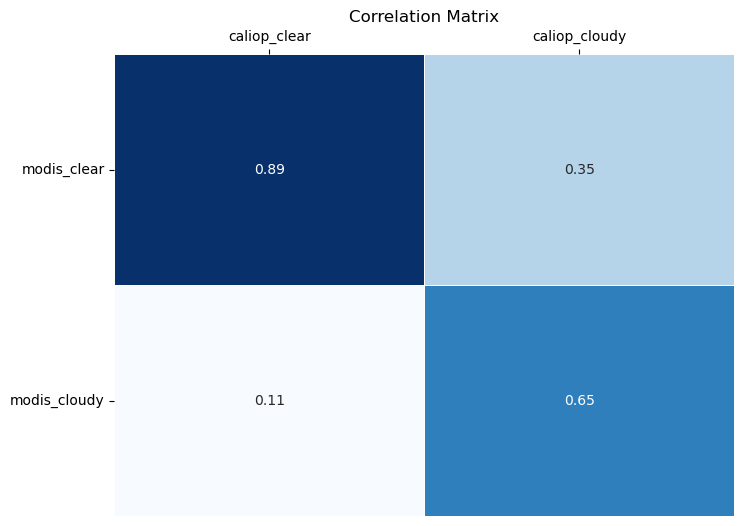

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming caliop_phase and modis_infrared_phase are DataFrames

# Calculate correlation values
caliop_cloudy_modis_cloudy = sum(merged_df.cCloudy.values & merged_df.mCloudy.values) / sum(merged_df.cCloudy.values)
caliop_cloudy_modis_clear = sum(merged_df.cCloudy.values & merged_df.mClear.values) / sum(merged_df.cCloudy.values)
caliop_clear_modis_cloudy = sum(merged_df.cClear.values & merged_df.mCloudy.values) / sum(merged_df.cClear.values)
caliop_clear_modis_clear = sum(merged_df.cClear.values & merged_df.mClear.values) / sum(merged_df.cClear.values)

correlation_table = pd.DataFrame({
    'modis_clear': [caliop_clear_modis_clear, caliop_cloudy_modis_clear],
    'modis_cloudy': [caliop_clear_modis_cloudy, caliop_cloudy_modis_cloudy]
}, index=['caliop_clear', 'caliop_cloudy'])

# Display correlation table
print(correlation_table)

# Create a 2 by 2 grid plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot correlation matrix with x and y axes swapped
sns.heatmap(correlation_table.T, cmap="Blues", annot=True, fmt=".2f", linewidths=.5, ax=ax, cbar=False)

# Set plot labels
ax.set_title("Correlation Matrix")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()  # Place x-axis labels on top

# Show the plot
plt.show()

#### Display corellation matrix for cloud-phase

              modis_clear  modis_water  modis_ice  modis_undetermined
caliop_water     0.182268     0.067507   0.091809            0.658416
caliop_ice       0.372713     0.010591   0.461850            0.154846


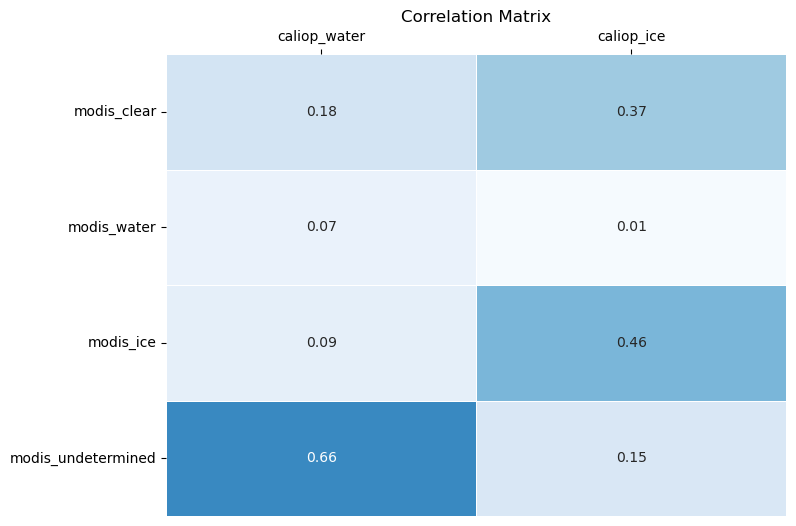

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_df is a DataFrame containing relevant data

# Calculate correlation values
caliop_water_modis_water = sum(merged_df.cWater.values & merged_df.mWater.values) / sum(merged_df.cWater.values)
caliop_water_modis_ice = sum(merged_df.cWater.values & merged_df.mIce.values) / sum(merged_df.cWater.values)
caliop_water_modis_undetermined = sum(merged_df.cWater.values & merged_df.mUndetermined.values) / sum(merged_df.cWater.values)
caliop_water_modis_clear = sum(merged_df.cWater.values & merged_df.mClear.values) / sum(merged_df.cWater.values)

caliop_ice_modis_water = sum(merged_df.cIce.values & merged_df.mWater.values) / sum(merged_df.cIce.values)
caliop_ice_modis_ice = sum(merged_df.cIce.values & merged_df.mIce.values) / sum(merged_df.cIce.values)
caliop_ice_modis_undetermined = sum(merged_df.cIce.values & merged_df.mUndetermined.values) / sum(merged_df.cIce.values)
caliop_ice_modis_clear = sum(merged_df.cIce.values & merged_df.mClear.values) / sum(merged_df.cIce.values)

# Create a DataFrame with the calculated values
correlation_table = pd.DataFrame({
    'modis_clear': [caliop_water_modis_clear, caliop_ice_modis_clear],
    'modis_water': [caliop_water_modis_water, caliop_ice_modis_water],
    'modis_ice': [caliop_water_modis_ice, caliop_ice_modis_ice],
    'modis_undetermined': [caliop_water_modis_undetermined, caliop_ice_modis_undetermined]
}, index=['caliop_water', 'caliop_ice'])

# Display correlation table
print(correlation_table)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot correlation matrix
sns.heatmap(correlation_table.T, cmap="Blues", annot=True, fmt=".2f", linewidths=.5, ax=ax, cbar=False, vmin=0, vmax=1)

# Set plot labels
ax.set_title("Correlation Matrix")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.tick_top()  # Place x-axis labels on top

# Show the plot
plt.show()


# Print MODIS filenames for database search and download

In [16]:
# print the unique mFileID entries followed and ended by the * character on separate new lines from the ./collocation_database/merged_collocations.csv file
import pandas as pd
import numpy as np

collocation_database = pd.read_csv("./collocation_database/2017/02/merged_collocations2017_02.csv")
for file_id in collocation_database.mFileID.unique():
    print(f"MYD021KM.{file_id}*")

# print(len(collocation_database.mFileID.unique()))


MYD021KM.A2017036.1420*
MYD021KM.A2017035.1335*
MYD021KM.A2017035.1340*
MYD021KM.A2017039.1135*
MYD021KM.A2017038.1405*
MYD021KM.A2017038.1410*
MYD021KM.A2017033.1530*
MYD021KM.A2017032.1440*
MYD021KM.A2017036.0750*
MYD021KM.A2017033.1210*
MYD021KM.A2017034.0625*
MYD021KM.A2017034.0630*
MYD021KM.A2017034.0445*
MYD021KM.A2017034.0450*
MYD021KM.A2017037.1325*
MYD021KM.A2017032.1445*
MYD021KM.A2017034.1435*
MYD021KM.A2017038.1230*
MYD021KM.A2017038.0600*
MYD021KM.A2017038.0605*
MYD021KM.A2017039.0640*
MYD021KM.A2017039.0645*
MYD021KM.A2017033.1215*
MYD021KM.A2017037.1145*
MYD021KM.A2017038.0735*
MYD021KM.A2017038.0740*
MYD021KM.A2017038.1540*
MYD021KM.A2017038.1545*
MYD021KM.A2017036.1425*
MYD021KM.A2017039.0505*
MYD021KM.A2017039.0510*
MYD021KM.A2017032.0815*
MYD021KM.A2017035.1515*
MYD021KM.A2017035.1520*
MYD021KM.A2017034.1255*
MYD021KM.A2017035.1200*
MYD021KM.A2017037.0515*
MYD021KM.A2017037.0520*
MYD021KM.A2017036.1245*
MYD021KM.A2017036.0925*
MYD021KM.A2017036.0930*
MYD021KM.A201703

In [171]:
# print the unique mFileID entries followed and ended by the * character on separate new lines from the ./collocation_database/merged_collocations.csv file
import pandas as pd
import numpy as np

collocation_database = pd.read_csv("./collocation_database/merged_collocations.csv")
for file_id in collocation_database.mFileID.unique():
    print(f"MCD12C1.{file_id}*")

# print(len(collocation_database.mFileID.unique()))

MCD12C1.A2017036.1420*
MCD12C1.A2017035.1335*
MCD12C1.A2017035.1340*
MCD12C1.A2017039.1135*
MCD12C1.A2017038.1405*
MCD12C1.A2017038.1410*
MCD12C1.A2017033.1530*
MCD12C1.A2017032.1445*
MCD12C1.A2017036.0750*
MCD12C1.A2017033.1210*
MCD12C1.A2017034.0625*
MCD12C1.A2017034.0630*
MCD12C1.A2017034.0445*
MCD12C1.A2017034.0450*
MCD12C1.A2017037.1325*
MCD12C1.A2017034.1435*
MCD12C1.A2017038.1230*
MCD12C1.A2017038.0600*
MCD12C1.A2017038.0605*
MCD12C1.A2017039.0640*
MCD12C1.A2017039.0645*
MCD12C1.A2017033.1215*
MCD12C1.A2017037.1145*
MCD12C1.A2017038.0735*
MCD12C1.A2017038.0740*
MCD12C1.A2017036.1425*
MCD12C1.A2017039.0505*
MCD12C1.A2017039.0510*
MCD12C1.A2017032.0815*
MCD12C1.A2017035.1515*
MCD12C1.A2017035.1520*
MCD12C1.A2017034.1255*
MCD12C1.A2017035.1200*
MCD12C1.A2017037.0515*
MCD12C1.A2017037.0520*
MCD12C1.A2017036.1245*
MCD12C1.A2017036.0925*
MCD12C1.A2017036.0930*
MCD12C1.A2017032.1130*
MCD12C1.A2017034.0800*
MCD12C1.A2017034.0805*
MCD12C1.A2017033.1350*
MCD12C1.A2017034.1115*
MCD12C1.A20

# Retrieving L1 MODIS data

## Play with file

Emissivity shape: (16, 406, 271)
Reflectances shape: (15, 406, 271)


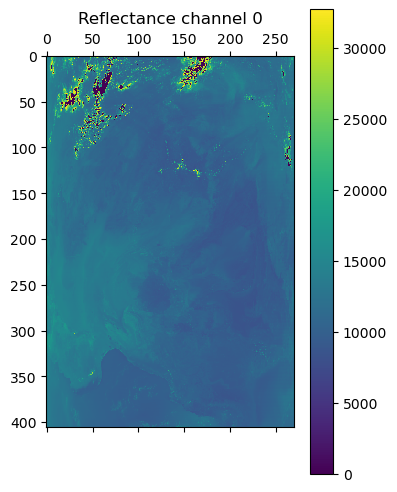

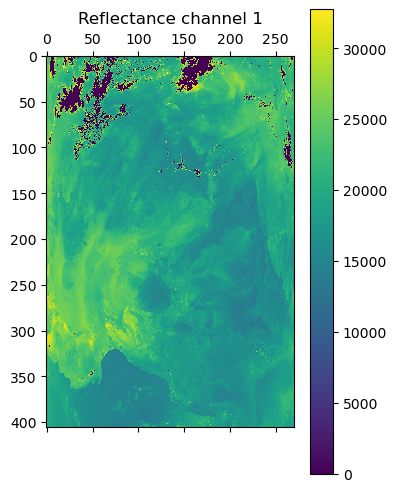

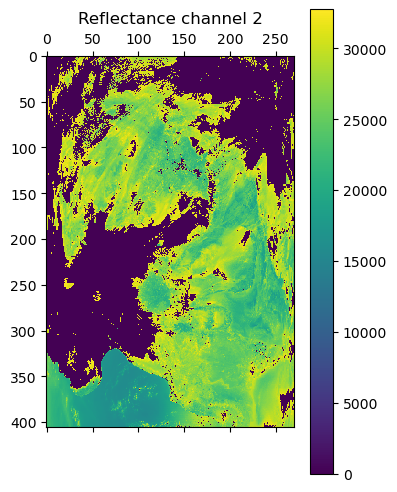

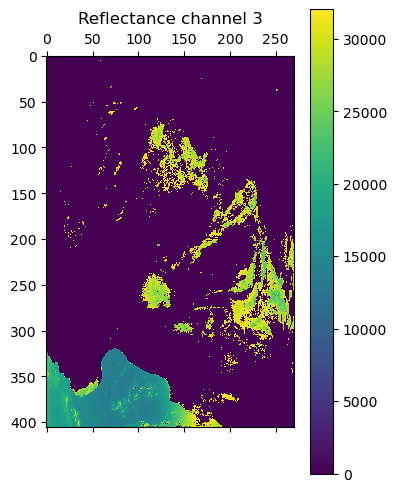

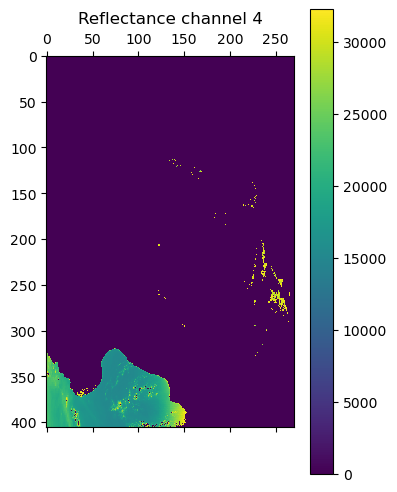

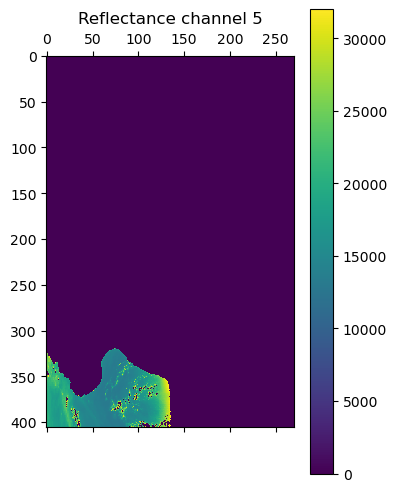

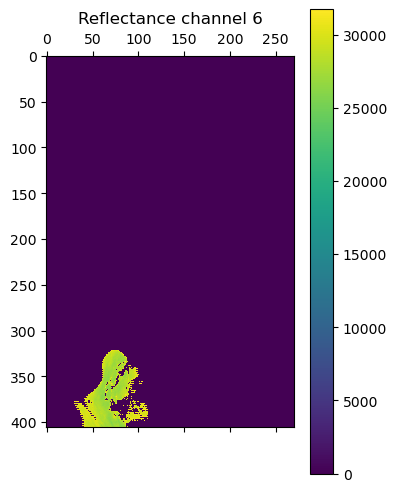

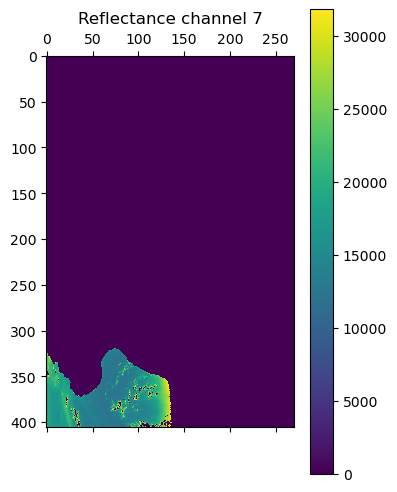

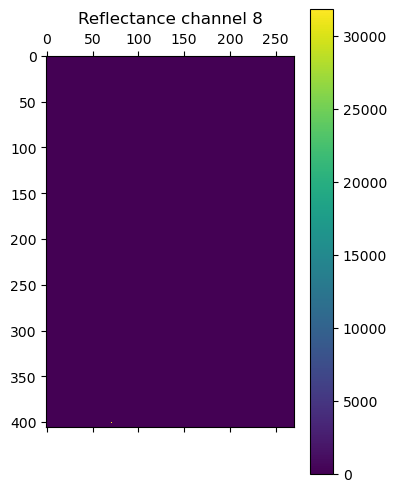

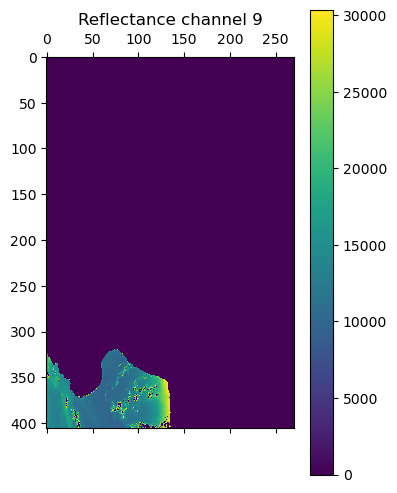

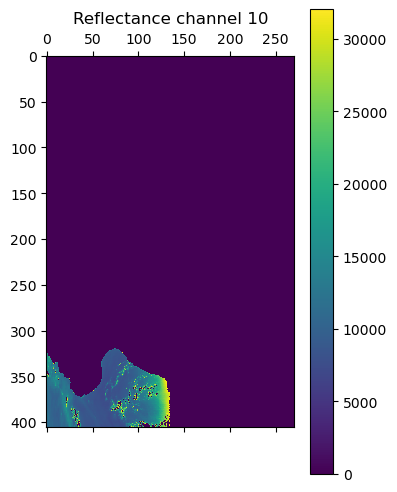

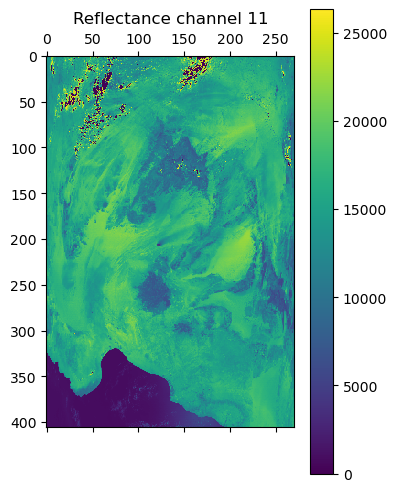

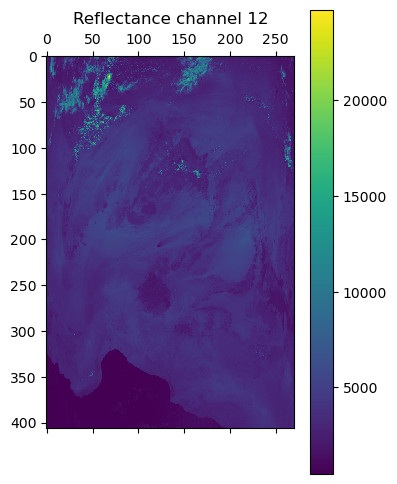

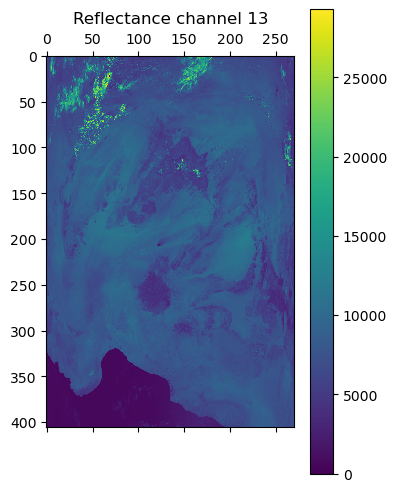

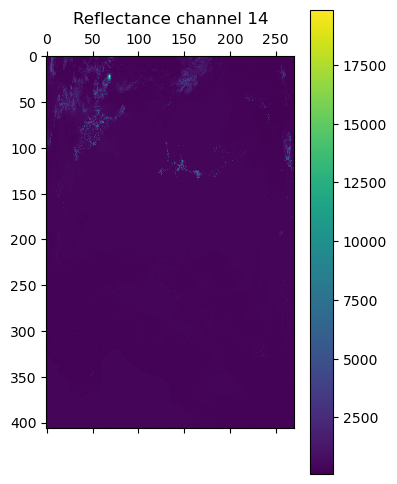

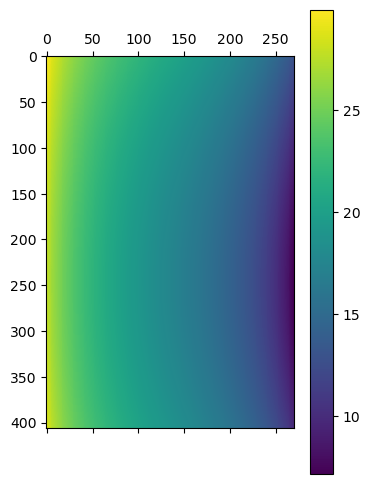

In [5]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os

prepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/"
# filepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/MYD02SSH.A2010004.1530.061.2018053190047.hdf"
filepath = os.path.join(prepath, "MYD02SSH.A2010188.1210.061.2018061015111.hdf")
reader = SD(filepath)

emissivities = reader.select("EV_1KM_Emissive").get()
reflectances = reader.select("EV_1KM_RefSB").get()

# get valid ranges for emissivity and reflectance from the hdf
emissivity_valid_range = reader.select("EV_1KM_Emissive").attributes().get("valid_range")
reflectance_valid_range = reader.select("EV_1KM_RefSB").attributes().get("valid_range")

# replace any values not in range with 0
emissivities = np.where((emissivities < emissivity_valid_range[0]) | (emissivities > emissivity_valid_range[1]), 0, emissivities)
reflectances = np.where((reflectances < reflectance_valid_range[0]) | (reflectances > reflectance_valid_range[1]), 0, reflectances)

# print emissivity shape
print(f"Emissivity shape: {emissivities.shape}")
# print reflectances shape
print(f"Reflectances shape: {reflectances.shape}")

# # plot the emisivity image for all channels
# for i in range(0, 16):
#     plt.matshow(emissivities[i,:,:])
#     plt.gca().set_title(f"Emissivity channel {i}")
#     plt.colorbar()

# plot the reflectance image for all channels
for i in range(0, 15):
    plt.matshow(reflectances[i,:,:])
    plt.gca().set_title(f"Reflectance channel {i}")
    plt.colorbar()

# get the solar zenith angle
solar_zenith = reader.select("SolarZenith").get()

# plot the solar zenith angle
plt.matshow(solar_zenith/100)
plt.colorbar()


## Get scales and offsets

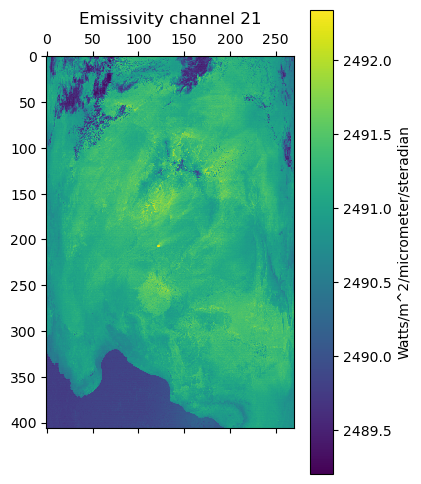

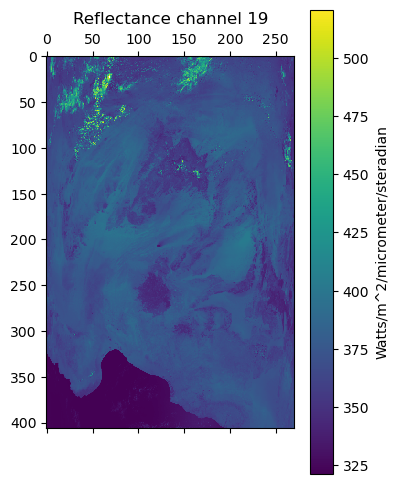

In [104]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os

prepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/"
# filepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/MYD02SSH.A2010004.1530.061.2018053190047.hdf"
filepath = os.path.join(prepath, "MYD02SSH.A2010188.1210.061.2018061015111.hdf")
reader = SD(filepath)

emissivities = reader.select("EV_1KM_Emissive").get()
reflectances = reader.select("EV_1KM_RefSB").get()

# get radiance scales and offsets from hdf file
em_radiance_scales = reader.select("EV_1KM_Emissive").attributes().get("radiance_scales")
em_radiance_offsets = reader.select("EV_1KM_Emissive").attributes().get("radiance_offsets")
ref_bands_1_2_radiance_scales = reader.select("EV_1KM_RefSB").attributes().get("radiance_scales")
ref_bands_1_2_radiance_offsets = reader.select("EV_1KM_RefSB").attributes().get("radiance_offsets")

# get valid ranges for emissivity and reflectance from the hdf
emissivity_valid_range = reader.select("EV_1KM_Emissive").attributes().get("valid_range")
reflectance_valid_range = reader.select("EV_1KM_RefSB").attributes().get("valid_range")

# replace emissivities and reflectances with a masked array where values are not in range
emissivities = np.ma.masked_where((emissivities < emissivity_valid_range[0]) | (emissivities > emissivity_valid_range[1]), emissivities)
reflectances = np.ma.masked_where((reflectances < reflectance_valid_range[0]) | (reflectances > reflectance_valid_range[1]), reflectances)

# broadcast the radiance scales and offsets to the shape of the emissivities and reflectances arrays
em_radiance_scales = np.tile(em_radiance_scales, (emissivities.shape[1], emissivities.shape[2], 1)).transpose((2, 0, 1))
em_radiance_offsets = np.tile(em_radiance_offsets, (emissivities.shape[1], emissivities.shape[2], 1)).transpose((2, 0, 1))
ref_bands_1_2_radiance_scales = np.tile(ref_bands_1_2_radiance_scales, (reflectances.shape[1], reflectances.shape[2], 1)).transpose((2, 0, 1))
ref_bands_1_2_radiance_offsets = np.tile(ref_bands_1_2_radiance_offsets, (reflectances.shape[1], reflectances.shape[2], 1)).transpose((2, 0, 1))

# apply radiance scales and offsets to emissivities and reflectances
emissivities = emissivities * em_radiance_scales + em_radiance_offsets
reflectances = reflectances * ref_bands_1_2_radiance_scales + ref_bands_1_2_radiance_offsets

# get units from hdf file
units = reader.select("EV_1KM_Emissive").attributes().get("radiance_units")

# get band names from hdf file
em_band_names = reader.select("EV_1KM_Emissive").attributes().get("band_names").split(",")
ref_band_names = reader.select("EV_1KM_RefSB").attributes().get("band_names").split(",")

# plot emissivities
em_channel = 1
plt.matshow(emissivities[em_channel,:,:])
plt.gca().set_title(f"Emissivity channel {em_band_names[em_channel]}")
plt.colorbar(label=units)

# plot reflectances
ref_channel = -2
plt.matshow(reflectances[ref_channel,:,:])
plt.gca().set_title(f"Reflectance channel {ref_band_names[ref_channel]}")
plt.colorbar(label=units)

## Build more general function

In [136]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os

prepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/"
filepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/MYD02SSH.A2010004.1530.061.2018053190047.hdf"
# filepath = os.path.join(prepath, "MYD02SSH.A2010188.1210.061.2018061015111.hdf")
reader = SD(filepath)

# bands 1-2 (inclusive) are found in EV_250_Aggr1km_RefSB, bands 3-7 in EV_500_Aggr1km_RefSB, bands 8-19 (and a bonus band 26) in EV_1KM_RefSB and bands 20-36 (except band 26) in EV_1KM_Emissive. Source https://modis.gsfc.nasa.gov/about/specifications.php, https://ladsweb.modaps.eosdis.nasa.gov/filespec/MODIS/61/MOD02SSH
variables_to_extract = ["EV_250_Aggr1km_RefSB", "EV_500_Aggr1km_RefSB", "EV_1KM_RefSB", "EV_1KM_Emissive"]


def get_modis_l1_data(filepath, variables_to_extract):
    # parameter validation
    if not os.path.exists(filepath):
        print("The given MODIS file does not exist.")
        return
    
    # try to open the file
    try:
        reader = SD(filepath)
    except HDF4Error:
        print("The given MODIS file could not be opened.")
        return

    data = [0] * len(variables_to_extract)
    band_names = []
    for index, variable in enumerate(variables_to_extract):
        extracted_data = reader.select(variable).get()

        # get valid range for reflectance from hdf file
        valid_range = reader.select(variable).attributes().get("valid_range")

        # replace reflectances with a masked array where values are not in range
        extracted_data = np.ma.masked_where((extracted_data < valid_range[0]) | (extracted_data > valid_range[1]), extracted_data)
        
        # get radiance scales and offsets for both datasets from hdf file
        radiance_scales = reader.select(variable).attributes().get("radiance_scales")
        radiance_offsets = reader.select(variable).attributes().get("radiance_offsets")

        # broadcast the radiance scales and offsets to the shape of the reflectances array
        radiance_scales = np.tile(radiance_scales, (extracted_data.shape[1], extracted_data.shape[2], 1)).transpose((2, 0, 1))
        radiance_offsets = np.tile(radiance_offsets, (extracted_data.shape[1], extracted_data.shape[2], 1)).transpose((2, 0, 1))

        # apply radiance scales and offsets to reflectances
        extracted_data = radiance_scales * (extracted_data - radiance_offsets)

        data[index] = extracted_data
        band_names.append(reader.select(variable).attributes().get("band_names").split(","))

    data = np.ma.concatenate(data, axis=0)

    # get rid of the last column of pixels, I should have 406x270 not 406x271
    data = data[:, :, :-1]

    # flatten the band names list
    band_names = ["band_" + item for sublist in band_names for item in sublist]

    # get pixel id
    pixel_id = np.arange(data.shape[1] * data.shape[2])

    # save the data into a dataframe, with the band names as column names, and the rows as the masked values in data
    df = pd.DataFrame(data.reshape((data.shape[0], data.shape[1] * data.shape[2])).transpose(), columns=band_names, index=pixel_id)

    return df

df = get_modis_l1_data(filepath, variables_to_extract)

df.head()
# print the number of Nan values in the dataframe
print(df.isna().sum().sum())
print(df.shape)

2411643
(109620, 38)


# Retrieving land surface temperature L2 data

## Play with file

surface_temp    83209
dtype: int64
110160


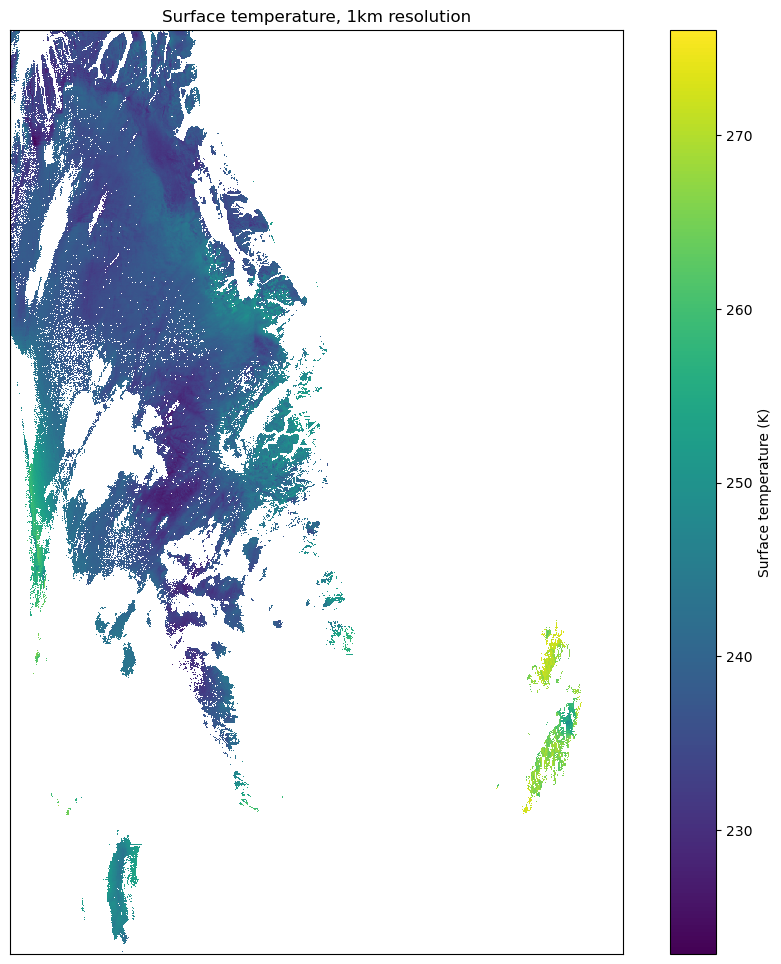

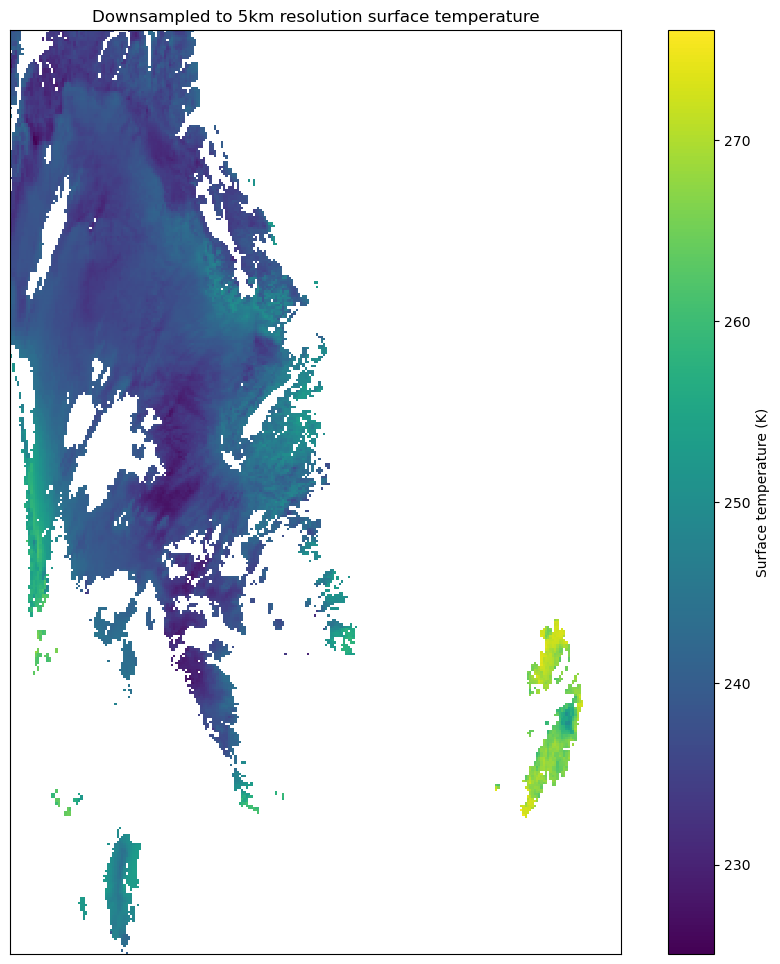

In [170]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os

prepath = "./test_data_first_feb_week/MODIS_surface_temp/2017/02/"
filename = "MYD11_L2.A2017032.0500.061.2022024120959.hdf"
filepath = os.path.join(prepath, filename)

reader = SD(filepath)

# get the surface temperature (LST)
surface_temp = reader.select("LST").get()

# get valid range for surface temperature from hdf file
valid_range = reader.select("LST").attributes().get("valid_range")

# replace surface temperature with a masked array where values are not in range
surface_temp = np.ma.masked_where((surface_temp < valid_range[0]) | (surface_temp > valid_range[1]), surface_temp)

# get scale factor
scale_factor = reader.select("LST").attributes().get("scale_factor")

# apply scale factor
surface_temp = surface_temp * scale_factor

# plot the 1km surface temperature
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(surface_temp)
ax.set_title("Surface temperature, 1km resolution")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax)
cbar.set_label("Surface temperature (K)")

# downsampling function that takes an array and downsamples it to a given pixel size by taking the average of the subpixels, while ignoring the masked values
def downsample_masked_array_by_mean(input_masked_array, pixelXsize=5, pixelYsize=5)
    rows, cols = input_masked_array.shape

    # reduce array to reshapeable size
    rows, cols = rows//pixelXsize * pixelXsize, cols//pixelYsize * pixelYsize
    input_masked_array = input_masked_array[:rows, :cols]

    # the dimensions of the output array
    rows, cols = rows//pixelXsize, cols//pixelYsize
    
    # reshape to 3d array where each axb pixel contains an array of a*b subpixels
    reshaped_array = np.ma.reshape(input_masked_array, (rows, pixelXsize, cols, pixelYsize)).transpose((0, 2, 1, 3)).reshape(rows, cols, pixelXsize*pixelYsize)

    # take mean while ignoring masked values
    output_array = np.ma.mean(reshaped_array, axis=2)
    
    return output_array

surface_temp_downsampled = downsample_masked_array_by_mean(surface_temp)

# plot the downsampled surface temperature
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(surface_temp_downsampled)
ax.set_title("Downsampled to 5km resolution surface temperature")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax)
cbar.set_label("Surface temperature (K)")


pixel_id = pd.Series(np.arange(surface_temp_downsampled.shape[0] * surface_temp_downsampled.shape[1]), name="pixel_id")

df = pd.DataFrame(surface_temp_downsampled.flatten(), columns=["surface_temp"], index=pixel_id)
df.head()

# print the number of Nan values in the dataframe
print(df.isna().sum())
print(len(df))


## Build general retrieval function

In [ ]:
# written directly in the get_feature_sets.py file

# Get land surface type information from L3 products

## From MCD12Q1 files

Too time-consuming. I don't know how to get coords.

{'LC_Type1': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 0), 'LC_Type2': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 1), 'LC_Type3': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 2), 'LC_Type4': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 3), 'LC_Type5': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 4), 'LC_Prop1_Assessment': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 5), 'LC_Prop2_Assessment': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 6), 'LC_Prop3_Assessment': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 7), 'LC_Prop1': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 8), 'LC_Prop2': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 9), 'LC_Prop3': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 10), 'QC': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 11), 'LW': (('YDim:MCD12Q1', 'XDim:MCD12Q1'), (2400, 2400), 21, 12)}


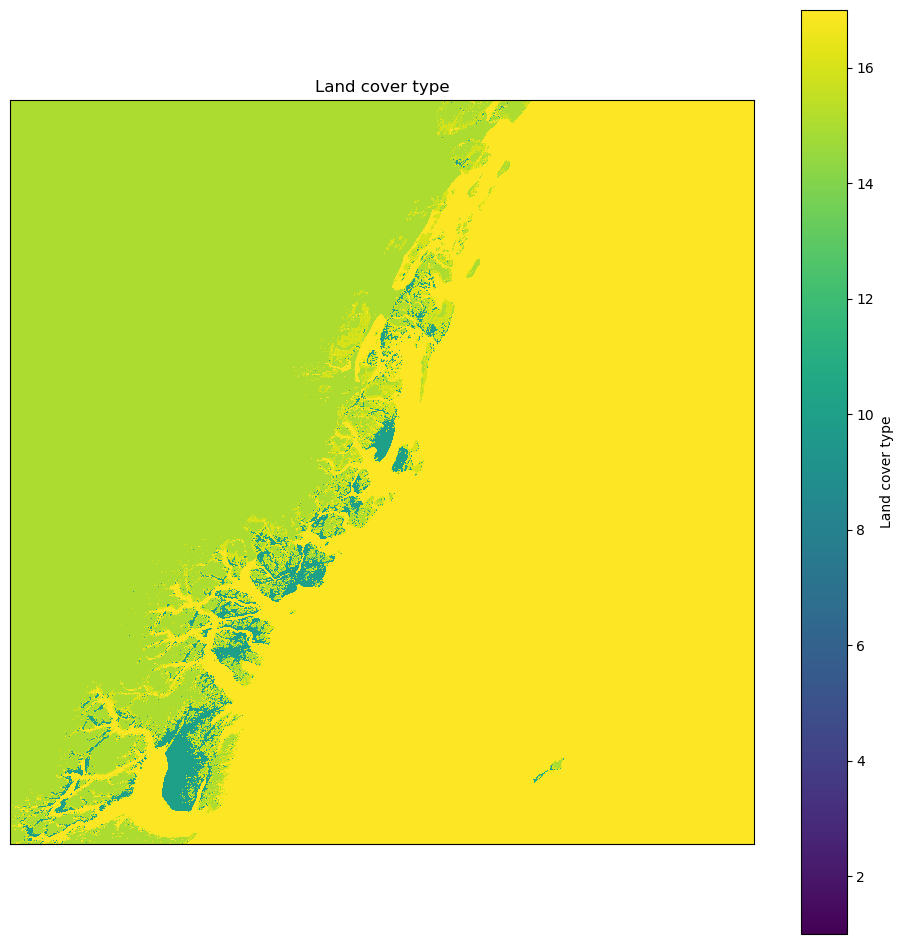

In [186]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os
import numpy as np
import cartopy.crs as ccrs

prepath = "./test_data_first_feb_week/MODIS_L3_surface_type"
filename = "MCD12Q1.A2017001.h17v01.061.2022168054522.hdf"
filepath = os.path.join(prepath, filename)

reader = SD(filepath)

# get hdf variables
variables = reader.datasets()
print(variables)

# get IGBP land cover type
land_cover_type = reader.select("LC_Type1").get()

# get fill value
fill_value = reader.select("LC_Type1").attributes().get("_FillValue")

# mask the fill values
# land_cover_type = np.ma.masked_where(land_cover_type == fill_value, land_cover_type)

# plot the land cover type
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.matshow(land_cover_type)
ax.set_title("Land cover type")
plt.xticks([])
plt.yticks([])
cbar = fig.colorbar(cax)
cbar.set_label("Land cover type")


## From a MCD12C1 file

### Read file, combine classifications, plot

{'Majority_Land_Cover_Type_1': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 0), 'Majority_Land_Cover_Type_1_Assessment': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 1), 'Land_Cover_Type_1_Percent': (('YDim:MOD12C1', 'XDim:MOD12C1', 'Num_IGBP_Classes:MOD12C1'), (3600, 7200, 17), 21, 2), 'Majority_Land_Cover_Type_2': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 3), 'Majority_Land_Cover_Type_2_Assessment': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 4), 'Land_Cover_Type_2_Percent': (('YDim:MOD12C1', 'XDim:MOD12C1', 'Num_UMD_Classes:MOD12C1'), (3600, 7200, 14), 21, 5), 'Majority_Land_Cover_Type_3': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 6), 'Majority_Land_Cover_Type_3_Assessment': (('YDim:MOD12C1', 'XDim:MOD12C1'), (3600, 7200), 21, 7), 'Land_Cover_Type_3_Percent': (('YDim:MOD12C1', 'XDim:MOD12C1', 'Num_LAI_FPAR_Classes:MOD12C1'), (3600, 7200, 11), 21, 8)}


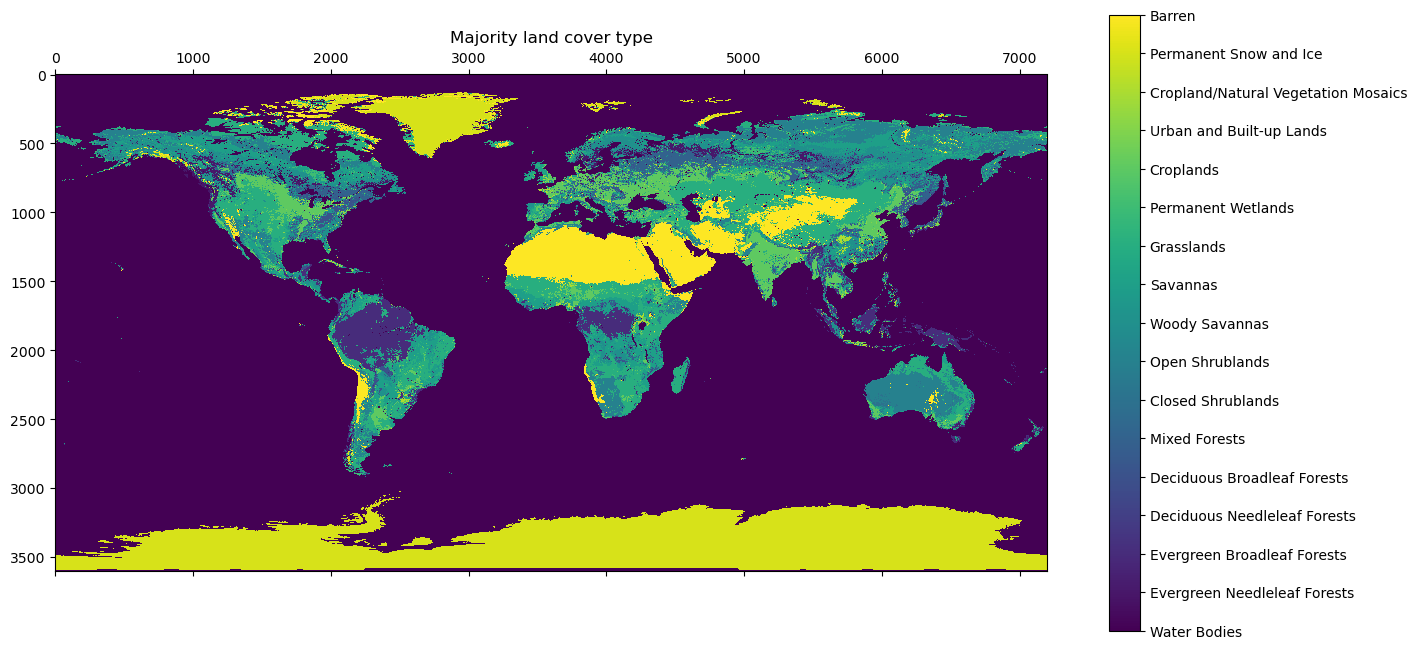

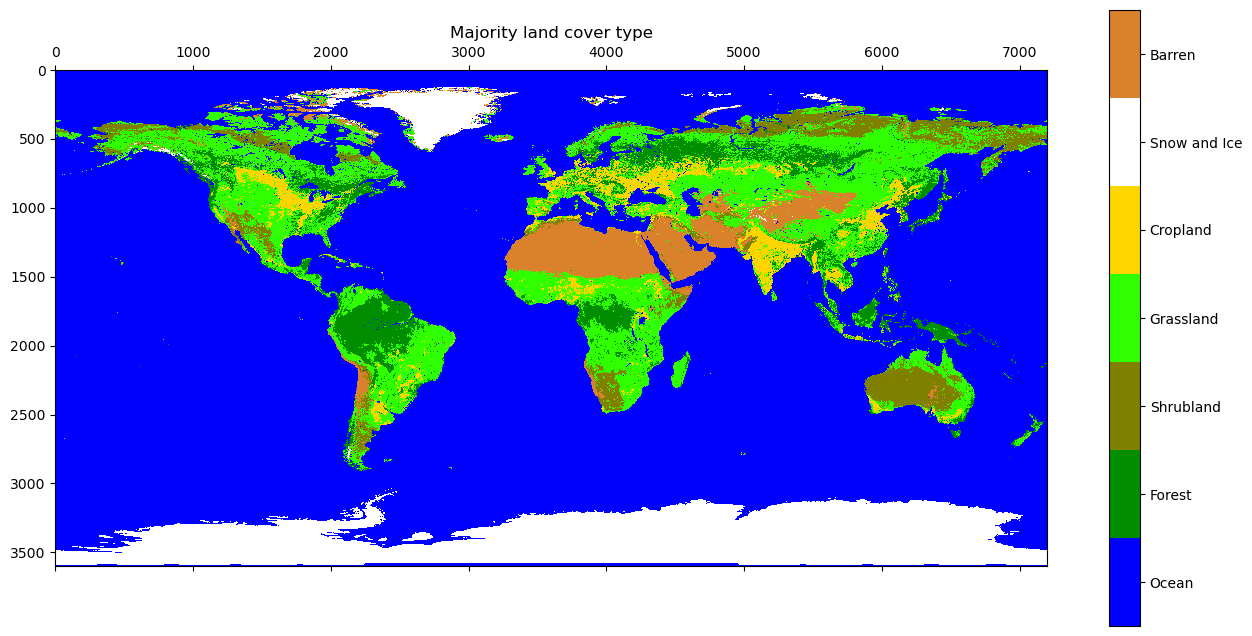

In [227]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os
import numpy as np
import cartopy.crs as ccrs

filepath = "/Users/alexandrudobra/University/MPhys/Project/MPhys_repo/LIDAR-Cloud-Phase-Detection/test_data/other_MODIS/MCD12C1.A2017001.061.2022168170603.hdf"

# Legend for land cover types
"""
Name Value Description
Water Bodies 0 At least 60% of area is covered by permanent wa-
ter bodies.
Evergreen Needleleaf Forests 1 Dominated by evergreen conifer trees (canopy
>2m). Tree cover >60%.
Evergreen Broadleaf Forests 2 Dominated by evergreen broadleaf and palmate
trees (canopy >2m). Tree cover >60%.
Deciduous Needleleaf Forests 3 Dominated by deciduous needleleaf (larch) trees
(canopy >2m). Tree cover >60%.
Deciduous Broadleaf Forests 4 Dominated by deciduous broadleaf trees (canopy
>2m). Tree cover >60%.
Mixed Forests 5 Dominated by neither deciduous nor evergreen
(40-60% of each) tree type (canopy >2m). Tree
cover >60%.
Closed Shrublands 6 Dominated by woody perennials (1-2m height)
>60% cover.
Open Shrublands 7 Dominated by woody perennials (1-2m height)
10-60% cover.
Woody Savannas 8 Tree cover 30-60% (canopy >2m).
Savannas 9 Tree cover 10-30% (canopy >2m).
Grasslands 10 Dominated by herbaceous annuals (<2m).
Permanent Wetlands 11 Permanently inundated lands with 30-60% water
cover and >10% vegetated cover.
Croplands 12 At least 60% of area is cultivated cropland.
Urban and Built-up Lands 13 At least 30% impervious surface area including
building materials, asphalt, and vehicles.
Cropland/Natural Vegetation Mo-
saics
14 Mosaics of small-scale cultivation 40-60% with
natural tree, shrub, or herbaceous vegetation.
Permanent Snow and Ice 15 At least 60% of area is covered by snow and ice
for at least 10 months of the year.
Barren 16 At least 60% of area is non-vegetated barren
(sand, rock, soil) areas with less than 10% veg-
etation.
"""

reader = SD(filepath)

# create list of land cover type names
land_cover_type_names = ["Water Bodies", "Evergreen Needleleaf Forests", "Evergreen Broadleaf Forests", "Deciduous Needleleaf Forests", "Deciduous Broadleaf Forests", "Mixed Forests", "Closed Shrublands", "Open Shrublands", "Woody Savannas", "Savannas", "Grasslands", "Permanent Wetlands", "Croplands", "Urban and Built-up Lands", "Cropland/Natural Vegetation Mosaics", "Permanent Snow and Ice", "Barren"]

# get the majority land cover type
majority_land_cover_type = reader.select("Majority_Land_Cover_Type_1").get()

# print hdf variables
print(reader.datasets())

# plot the majority land cover type
fig, ax = plt.subplots(figsize=(16,8))
cax = ax.matshow(majority_land_cover_type)
ax.set_title("Majority land cover type")
cbar = fig.colorbar(cax, ticks=np.arange(0, 17))
cbar.set_ticklabels(land_cover_type_names)

combined_category_names = ["Ocean", "Forest"]

# combine the forest types (and additionally wetlands) into one category "Forest"
forest_types = [1, 2, 3, 4, 5, 11]
majority_land_cover_type = np.where(np.isin(majority_land_cover_type, forest_types), 1, majority_land_cover_type)

# combine the shrubland types into one category "Shrubland"
shrubland_types = [6, 7]
majority_land_cover_type = np.where(np.isin(majority_land_cover_type, shrubland_types), 2, majority_land_cover_type)

# combine the savanna types, grasslands and urban types into "Grassland"
grassland_types = [8, 9, 10, 13]
majority_land_cover_type = np.where(np.isin(majority_land_cover_type, grassland_types), 3, majority_land_cover_type)

# combine cropland and vegetation into "Cropland"
cropland_types = [12, 14]
majority_land_cover_type = np.where(np.isin(majority_land_cover_type, cropland_types), 4, majority_land_cover_type)

# replace snow and ice marker with 5
majority_land_cover_type = np.where(majority_land_cover_type == 15, 5, majority_land_cover_type)

# replace barren marker with 7
majority_land_cover_type = np.where(majority_land_cover_type == 16, 7, majority_land_cover_type)

# make a list of the new land cover type names
combined_category_names = ["Ocean", "Forest", "Shrubland", "Grassland", "Cropland", "Snow and Ice", "Barren"]

# plot the new land cover type, with Ocean represented by pure blue (HTML notation 0000ff), Forest by 008d00, Shrubland by 808000, Grassland by 2fff00, Cropland by ffd500, Snow and Ice by ffffff and Barren by d9812b
land_cover_colormap = ["#0000ff", "#008d00", "#808000", "#2fff00", "#ffd500", "#ffffff", "#d9812b"]

# turn to linearly segmented colormap
land_cover_colormap = plt.cm.colors.LinearSegmentedColormap.from_list("land_cover_colormap", land_cover_colormap, N=len(land_cover_colormap))

fig, ax = plt.subplots(figsize=(16,8))
cax = ax.matshow(majority_land_cover_type, cmap=land_cover_colormap)
ax.set_title("Majority land cover type")
cbar = fig.colorbar(cax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar.set_ticklabels(combined_category_names)



### Build function that spits out land cover classification for given coordinates

  0%|          | 0/98 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
 15%|█▌        | 15/98 [00:00<00:03, 26.30it/s]

A2017032.1440 file not found


 26%|██▌       | 25/98 [00:00<00:02, 28.03it/s]

A2017033.1345 file not found


 44%|████▍     | 43/98 [00:01<00:02, 26.66it/s]

A2017035.1510 file not found


 89%|████████▉ | 87/98 [00:03<00:00, 28.16it/s]

A2017038.1540 file not found


100%|██████████| 98/98 [00:03<00:00, 26.27it/s]


Index(['mLong', 'mLat', 'mVZA', 'mSZA', 'mSnowIceCover'], dtype='object')
./test_data_first_feb_week/MODIS_L3_surface_type/MCD12C1.A2017001.061.2022168170603.hdf
(14282, 5)
-39.77416229248047 77.46697998046875


ERROR:tornado.general:SEND Error: Host unreachable


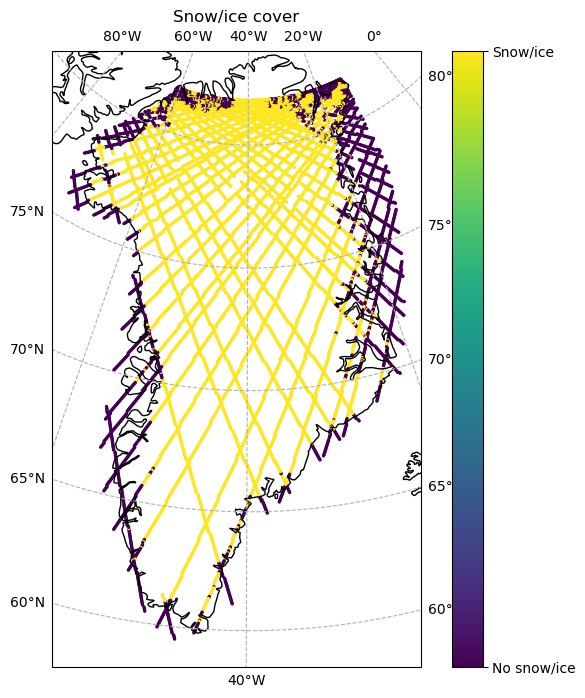

In [1]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import glob
import cartopy.crs as ccrs
from get_feature_sets import get_feature_sets

def get_snow_ice_cover_classification(L3_land_cover_folder, longitudes, latitudes, year_list):
    # check whether L3_land_cover_folder exists
    if not os.path.exists(L3_land_cover_folder):
        print("The given L3 land cover folder does not exist.")
        return

    # check whether year_list is a scalar and if it is, put it into a list the size of lats and longs
    if np.isscalar(year_list):
        year_list = np.full(np.shape(longitudes), year_list)

    snow_ice_cover = np.full(np.shape(longitudes), -1)
    unique_year_list = np.unique(year_list)

    for year in unique_year_list:
        # get the file path
        search_string = f"**/MCD12C1.A{year}*"
        file_path = glob.glob(search_string, root_dir=L3_land_cover_folder, recursive=True)

        # check if the file exists
        if len(file_path) == 0:
            print(f"File for year {year} not found.")
            continue
        
        # check if there are multiple files for the same year
        if len(file_path) > 1:
            print(f"Multiple files for year {year} found.")
            continue
        

        # complete filepath
        file_path = os.path.join(L3_land_cover_folder, file_path[0])
        print(file_path)

        # open the file
        reader = SD(file_path)

        # get the IGBP majority land cover type
        majority_land_cover_type = reader.select("Majority_Land_Cover_Type_1").get()

        # round down the longitudes and latitudes in the current year to the nearest 0.05 and convert to integers by multiplying by 20
        longitudes_rounded = np.floor(longitudes[(year_list == year)] / 0.05) + 3600
        latitudes_rounded = - np.floor(latitudes[(year_list == year)] / 0.05) + 1800

        # get a true or false value for snow/ice cover at the rounded longitudes and latitudes
        yearly_snow_ice_cover = majority_land_cover_type[latitudes_rounded.astype(int), longitudes_rounded.astype(int)] == 15

        # add the yearly snow/ice cover to the total snow/ice cover
        snow_ice_cover[year_list == year] = yearly_snow_ice_cover.astype(int)

    return snow_ice_cover


L3_land_cover_folder = "./test_data_first_feb_week/MODIS_L3_surface_type"
collocation_df = pd.read_csv("./collocation_database/2017/02/merged_collocations2017_02.csv")

modis_geo = get_feature_sets("modis_geo", "./test_data_first_feb_week/MODIS/", "./collocation_database/2017/02/merged_collocations2017_02.csv", kwargs={"surface_datapath": "./test_data_first_feb_week/MODIS_L3_surface_type"})
print(modis_geo.columns)

# make a test year_list that has 2016 for the first half of the data and 2017 for the second half
year_list = np.full(len(modis_geo), 2017)

snow_ice_cover = get_snow_ice_cover_classification(L3_land_cover_folder, modis_geo.mLong, modis_geo.mLat, year_list)

modis_geo["mSnowIceCover"] = snow_ice_cover
print(modis_geo.shape)
modis_geo.head(20)

# get central coordinates of dataset
central_long = modis_geo.mLong.median()
central_lat = modis_geo.mLat.median()

print(central_long, central_lat)

# plot the snow/ice cover on the long lat grid
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": ccrs.Orthographic(central_long, central_lat)})
cax = ax.scatter(modis_geo.mLong, modis_geo.mLat, c=modis_geo.mSnowIceCover, s=2, transform=ccrs.PlateCarree())
ax.set_title("Snow/ice cover")
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.grid
cbar = fig.colorbar(cax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["No snow/ice", "Snow/ice"])

# Getting land surface type information from MYD06
This is unusable.

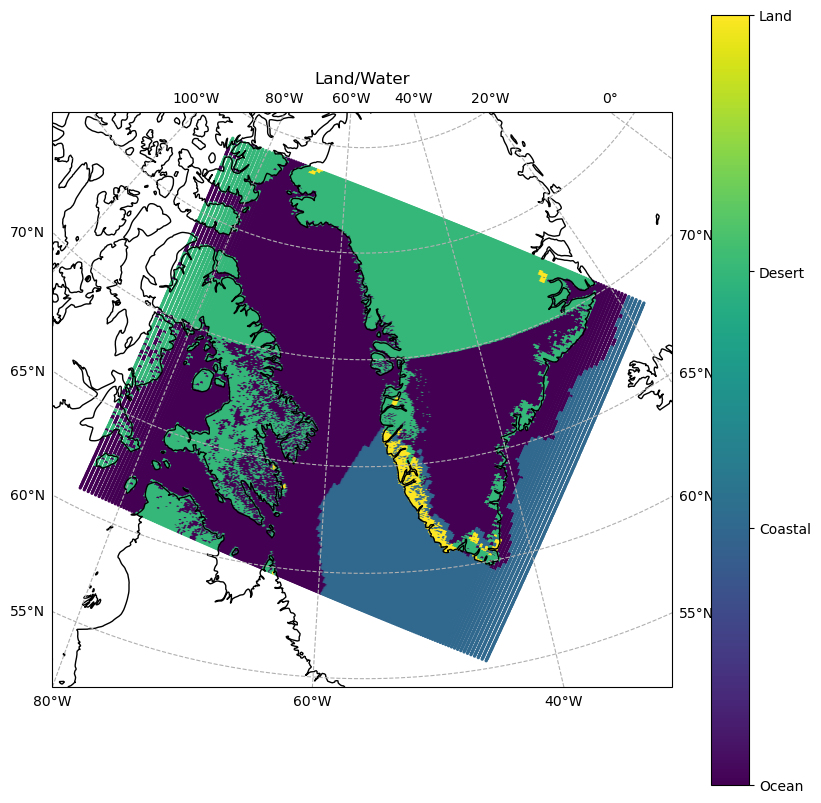

In [201]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

prepath = "./test_data_first_feb_week/MODIS/2017/02/"
# filename = "MYD06_L2.A2017032.0500.061.2018030154037.pscs_000502088436.hdf"
filename = "MYD06_L2.A2017032.0640.061.2018030154115.pscs_000502088436.hdf"
filepath = os.path.join(prepath, filename)

reader = SD(filepath)
# get latitude and longitude
latitude = reader.select("Latitude").get()
longitude = reader.select("Longitude").get()

modis_cloud_mask_1km = reader.select("Cloud_Mask_5km").get()[:,:,0]

def vectorized_parse_byte_properties(byte_array):
    # Vectorized version of parse_byte_properties function
    properties = {}

    # Bit 0: Cloud Mask Flag
    properties['Cloud Mask Flag'] = np.where((byte_array & 0b1) == 0, 'Not determined', 'Determined')

    # Bits 2-1: Unobstructed FOV Quality Flag
    quality_flag = (byte_array >> 1) & 0b11
    quality_mapping = {
        0b00: 'Cloudy',
        0b01: 'Uncertain',
        0b10: 'Probably Clear',
        0b11: 'Confident Clear'
    }
    properties['Unobstructed FOV Quality Flag'] = np.vectorize(quality_mapping.get)(quality_flag)

    # Bit 3: Day or Night Path
    properties['Day or Night Path'] = np.where((byte_array >> 2) & 0b1 == 0, 'Night', 'Day')

    # Bit 4: Sunglint Path
    properties['Sunglint Path'] = np.where((byte_array >> 3) & 0b1 == 0, 'Yes', 'No')

    # Bit 5: Snow/Ice Background Path
    properties['Snow/Ice Background Path'] = np.where((byte_array >> 4) & 0b1 == 0, 1, 0)

    # Bits 7-6: Land or Water Path
    land_water_flag = (byte_array >> 5) & 0b11
    land_water_mapping = {
        0b00: 0,
        0b01: 1,
        0b10: 2,
        0b11: 3
    }
    properties['Land or Water Path'] = np.vectorize(land_water_mapping.get)(land_water_flag)

    return properties

# Example usage with a NumPy array of bytes
byte_array = np.array(modis_cloud_mask_1km, dtype=np.uint8).flatten()
result = vectorized_parse_byte_properties(byte_array)

snow_ice_background = result['Snow/Ice Background Path'].reshape(modis_cloud_mask_1km.shape)
land_water = result['Land or Water Path'].reshape(modis_cloud_mask_1km.shape)

# find central longitude and latitude
modis_central_long = np.median(longitude)
modis_central_lat = np.median(latitude)

# plot the land/water
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs_projection})
cax = ax.scatter(longitude, latitude, c=land_water, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="dashed")
ax.set_title("Land/Water")
cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(["Ocean", "Coastal", "Desert", "Land"])



# Retrieve geographical and geometry information

Long, lat, VZA, SZA.

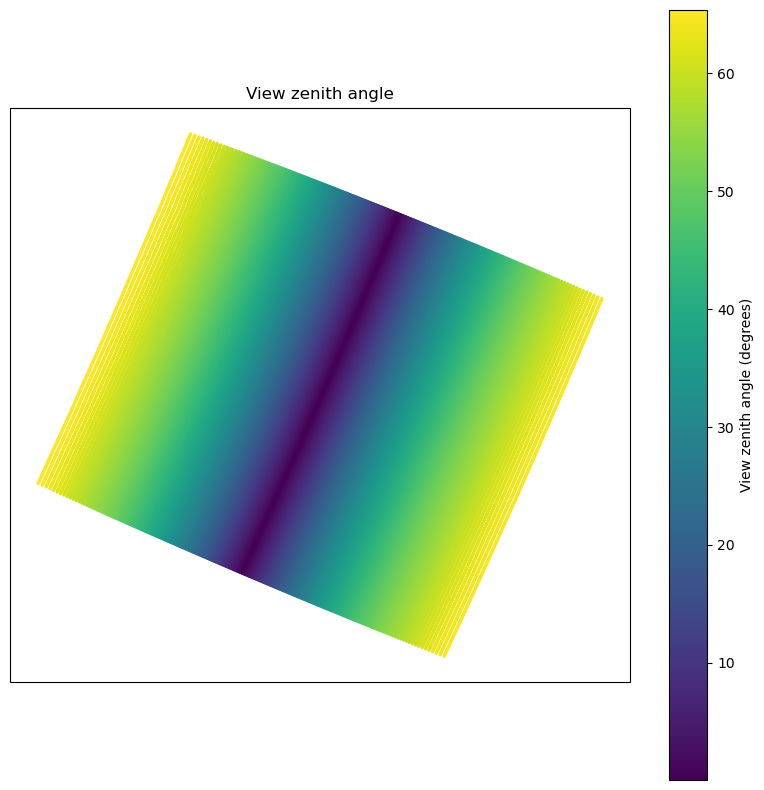

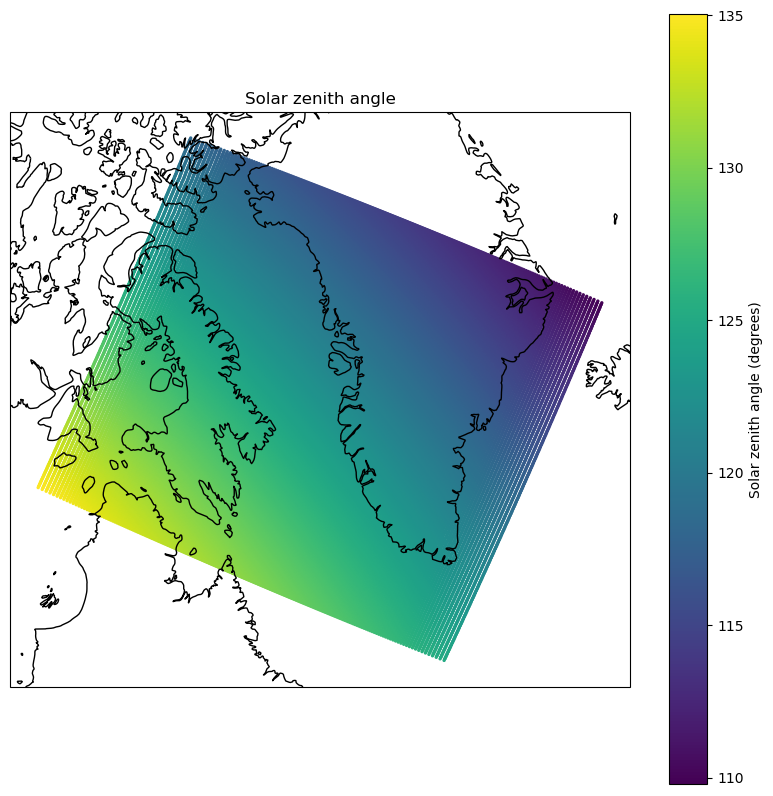

In [232]:
from pyhdf.SD import *
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

prepath = "./test_data_first_feb_week/MODIS/2017/02/"
# filename = "MYD06_L2.A2017032.0500.061.2018030154037.pscs_000502088436.hdf"
filename = "MYD06_L2.A2017032.0640.061.2018030154115.pscs_000502088436.hdf"
filepath = os.path.join(prepath, filename)

# prepath = "./test_data_first_feb_week/MODIS_surface_temp/2017/02/"
# filename = "MYD11_L2.A2017032.0500.061.2022024120959.hdf"
# filepath = os.path.join(prepath, filename)

# write a function that given a MODIS filepath, extracts the long, lat, VZA, SZA and returns them in a dataframe with pixel_id as index
def get_modis_geo_data(filepath):
    # parameter validation
    if not os.path.exists(filepath):
        print("The given MODIS file does not exist.")
        return
    
    # try to open the file
    try:
        reader = SD(filepath)
    except HDF4Error:
        print("The given MODIS file could not be opened.")
        return

    # get latitude and longitude
    latitude = reader.select("Latitude").get()
    longitude = reader.select("Longitude").get()

    # get view zenith angle
    view_zenith_angle = reader.select("Sensor_Zenith").get() / 100

    # get solar zenith angle
    solar_zenith_angle = reader.select("Solar_Zenith").get() / 100

    # get pixel id
    pixel_id = pd.Series(np.arange(np.size(latitude)), name="pixel_id")

    # save the data into a dataframe, with the band names as column names, and the rows as the masked values in data
    df = pd.DataFrame(np.array([longitude.flatten(), latitude.flatten(), view_zenith_angle.flatten(), solar_zenith_angle.flatten()]).transpose(), columns=["long", "lat", "VZA", "SZA"], index=pixel_id)

    return df

df = get_modis_geo_data(filepath)
df.head(20)
# df.shape

# find central longitude and latitude
modis_central_long = np.median(df.long)
modis_central_lat = np.median(df.lat)

# plot VZA with color on a long lat grid with Orthographic projection
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.Orthographic(modis_central_long, modis_central_lat)})
cax = ax.scatter(df.long, df.lat, c=df.VZA, s=2, transform=ccrs.PlateCarree())
ax.set_title("View zenith angle")
cbar = fig.colorbar(cax)
cbar.set_label("View zenith angle (degrees)")

# plot SZA with color on a long lat grid with Orthographic projection
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.Orthographic(modis_central_long, modis_central_lat)})
cax = ax.scatter(df.long, df.lat, c=df.SZA, s=2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Solar zenith angle")
cbar = fig.colorbar(cax)
cbar.set_label("Solar zenith angle (degrees)")


# Understanding CALIOP CAD score

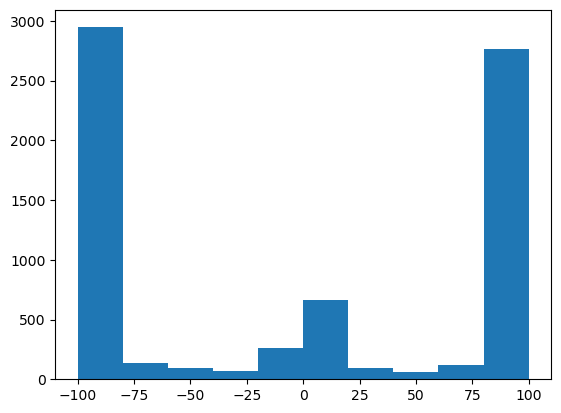

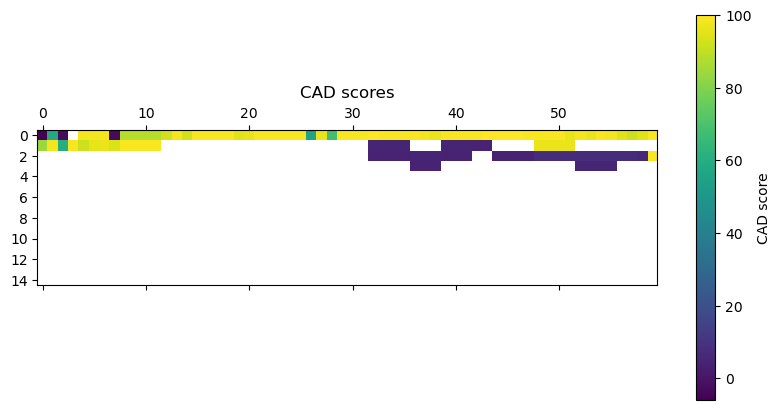

In [12]:
import os
from caliop import Caliop_hdf_reader

path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.hdf"
filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename)

# read CAD score from CALIOP file
reader = Caliop_hdf_reader()
CAD_scores = reader._get_calipso_data(filepath, "CAD_Score")

# further mask values outside of the range [-100, 100]
CAD_scores = np.ma.masked_where((CAD_scores < -100) | (CAD_scores > 100), CAD_scores)

# print a histogram of the CAD scores
plt.hist(CAD_scores.flatten())

# plot the CAD scores in the first 60 columns, and only those values over 20

fig, ax = plt.subplots(figsize=(10,5))
cax = ax.matshow(CAD_scores[:, :60])
# cax = ax.matshow(np.ma.masked_where(CAD_scores[:, :60] < 20, CAD_scores[:, :60]))
ax.set_title("CAD scores")
cbar = fig.colorbar(cax)
cbar.set_label("CAD score")


547


(array([ 78.,   0.,   0.,   0.,   0.,   0.,   0., 466.,   0.,   3.]),
 array([103. , 103.4, 103.8, 104.2, 104.6, 105. , 105.4, 105.8, 106.2,
        106.6, 107. ]),
 <BarContainer object of 10 artists>)

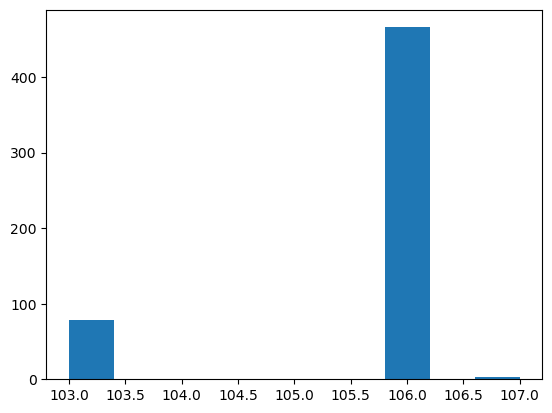

In [43]:
import os
from caliop import Caliop_hdf_reader

path_to_CALIOP_data = "./test_data/CALIOP/"
date_folder = "2017/01"
caliop_filename = "CAL_LID_L2_05kmMLay-Standard-V4-51.2017-01-01T13-52-38ZN.hdf"
filepath = os.path.join(path_to_CALIOP_data, date_folder, caliop_filename)

# read CAD score from CALIOP file
reader = Caliop_hdf_reader()
CAD_scores = reader._get_calipso_data(filepath, "CAD_Score")

_, layer_type = reader._get_feature_classification(filepath, "Feature_Classification_Flags")

# print the number of layer_type == 2 (clouds) values that do not have a CAD score between 0 and 100
print( np.sum((layer_type == 2) & ((CAD_scores < 0) | (CAD_scores > 100))) )
plt.hist(CAD_scores[(layer_type == 2) & ((CAD_scores < 0) | (CAD_scores > 100))])



In [44]:
invalid_any = np.where(np.any(layer_type == 0, axis=0), True, False)
invalid_all = np.where(np.all(layer_type == 0, axis=0), True, False)

print(np.sum(invalid_any))
print(np.sum(invalid_all))


0
0


# Explore cloud-top properties datasets

## How do the nadir MODIS products compare to the full-sized datasets?

(406, 270)
(406, 270)


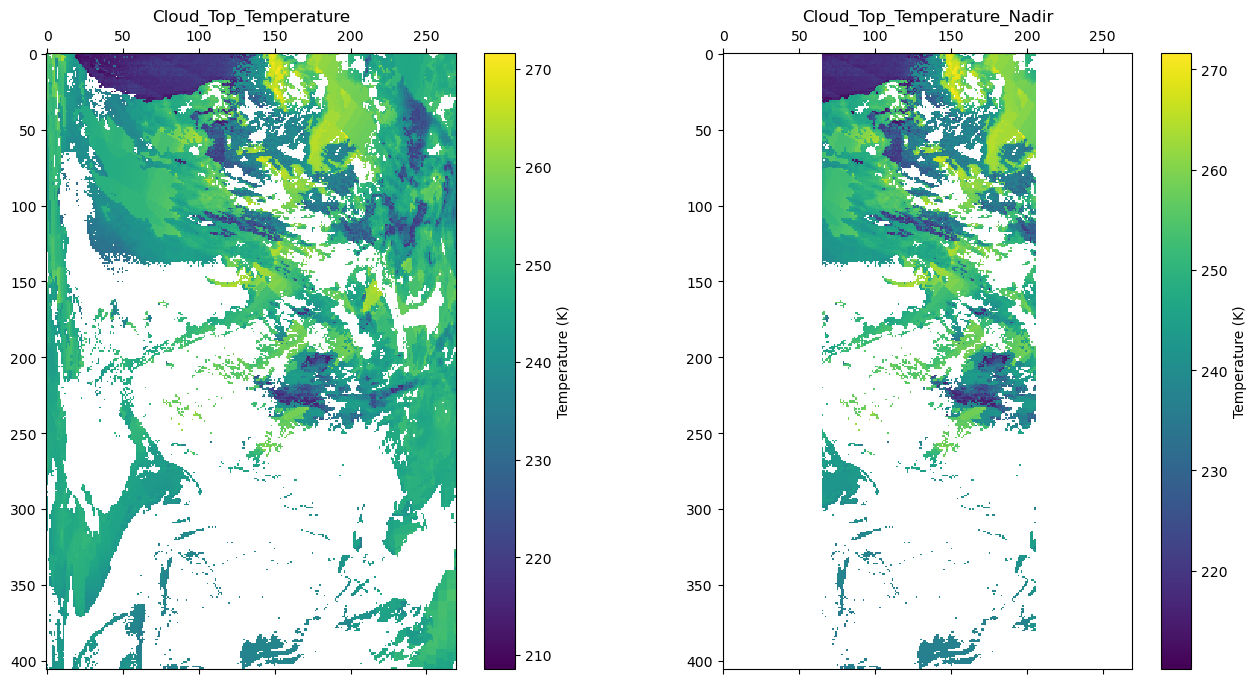

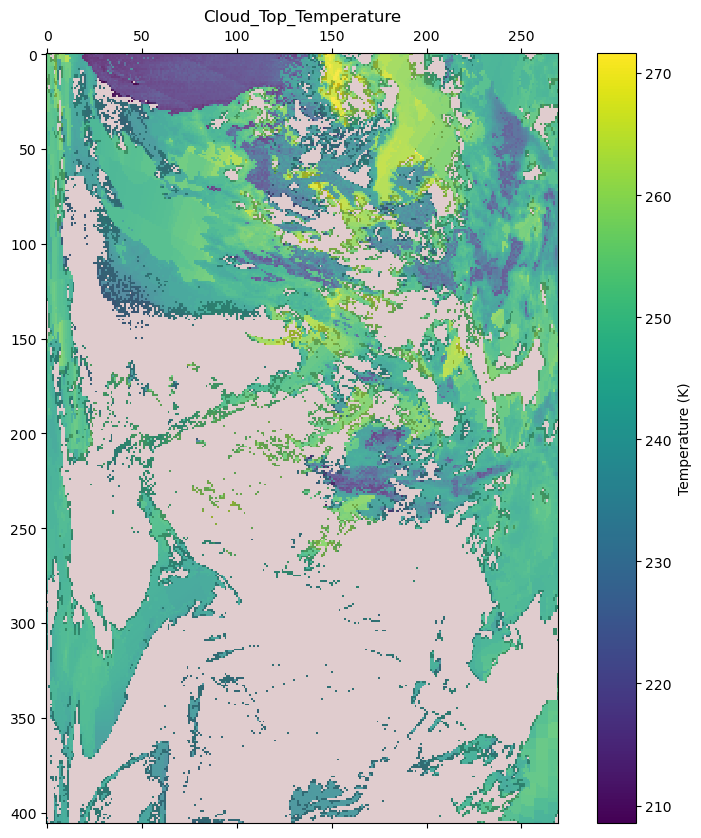

In [22]:
# read in a MYD06 file and load Cloud_Top_Temperature and Cloud_Top_Temperature_Nadir and compare their sizes
from pyhdf.SD import *
import os
import numpy as np
import matplotlib.pyplot as plt


prepath = "./test_data/MODIS/2017/01/01"
filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
filepath = os.path.join(prepath, filename)
reader = SD(filepath)

# get Cloud_Top_Temperature and Cloud_Top_Temperature_Nadir
cloud_top_temperature = reader.select("Cloud_Top_Temperature").get()
cloud_top_temperature_nadir = reader.select("Cloud_Top_Temperature_Nadir").get()

# get valid range for Cloud_Top_Temperature and Cloud_Top_Temperature_Nadir from hdf file
valid_range = reader.select("Cloud_Top_Temperature").attributes().get("valid_range")
valid_range_nadir = reader.select("Cloud_Top_Temperature_Nadir").attributes().get("valid_range")

# replace Cloud_Top_Temperature and Cloud_Top_Temperature_Nadir with a masked array where values are not in range
cloud_top_temperature = np.ma.masked_where((cloud_top_temperature < valid_range[0]) | (cloud_top_temperature > valid_range[1]), cloud_top_temperature)
cloud_top_temperature_nadir = np.ma.masked_where((cloud_top_temperature_nadir < valid_range_nadir[0]) | (cloud_top_temperature_nadir > valid_range_nadir[1]), cloud_top_temperature_nadir)

# get scales and offsets for the two datasets
scales = reader.select("Cloud_Top_Temperature").attributes().get("scale_factor")
offsets = reader.select("Cloud_Top_Temperature").attributes().get("add_offset")

scales_nadir = reader.select("Cloud_Top_Temperature_Nadir").attributes().get("scale_factor")
offsets_nadir = reader.select("Cloud_Top_Temperature_Nadir").attributes().get("add_offset")

# apply scales and offsets
cloud_top_temperature = scales * (cloud_top_temperature - offsets)
cloud_top_temperature_nadir = scales_nadir * (cloud_top_temperature_nadir - offsets_nadir)

# get the units
units = reader.select("Cloud_Top_Temperature").attributes().get("units")

# print the shapes of the two arrays
print(cloud_top_temperature.shape)
print(cloud_top_temperature_nadir.shape)

# plot the values of the two arrays in two subplots (with colorbars)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
cax0 = ax[0].matshow(cloud_top_temperature)
ax[0].set_title("Cloud_Top_Temperature")

cax1 = ax[1].matshow(cloud_top_temperature_nadir)
ax[1].set_title("Cloud_Top_Temperature_Nadir")

fig.colorbar(cax0, ax=ax[0], label=f"Temperature ({units})")
fig.colorbar(cax1, ax=ax[1], label=f"Temperature ({units})")

from get_feature_sets import get_modis_5km_cloud_phase

df_cloud_classification = get_modis_5km_cloud_phase(filepath)

# plot the cloud-top temperature as before, but now overlay the clear pixels over it, with the color red
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cloud_top_temperature, alpha=1)
ax.set_title("Cloud_Top_Temperature")
cbar = fig.colorbar(cax)
cbar.set_label(f"Temperature ({units})")
ax.matshow(df_cloud_classification.mClear.values.reshape(cloud_top_temperature.shape), cmap="Reds", alpha=0.2)

# set the cloud-top temperature colors to no transparancy (alpha=1)
cax.set_alpha(1)




## What is the difference between cloud-top properties based on CO2 retrievals and those based on "IR" retrievals?

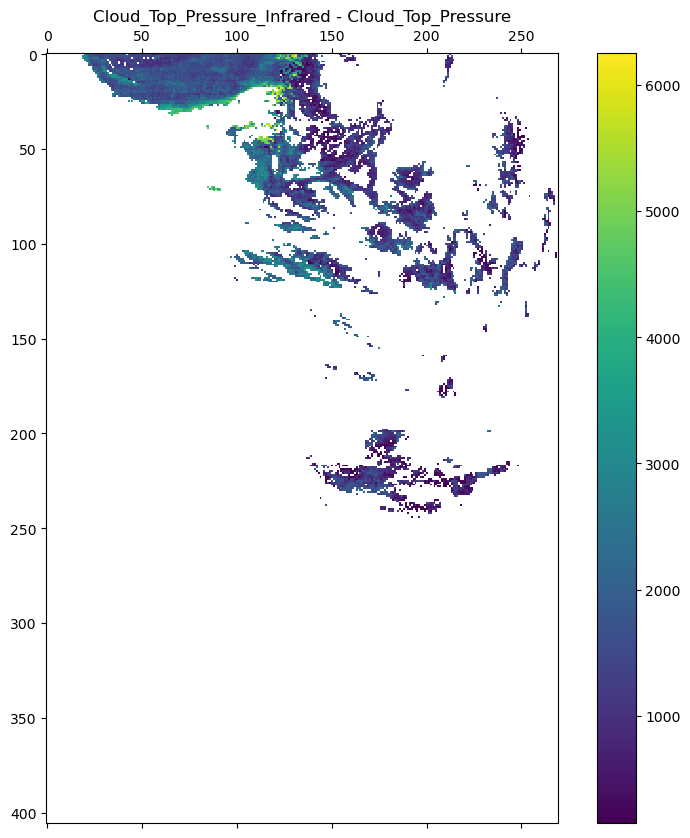

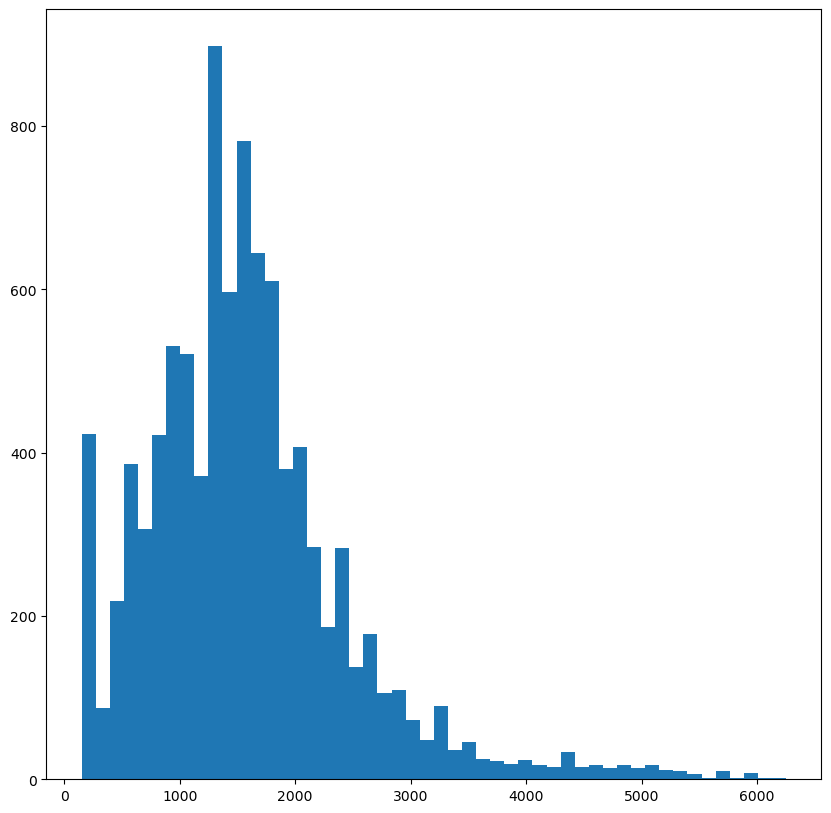

In [2]:
from pyhdf.SD import *
import os
import numpy as np
import matplotlib.pyplot as plt

prepath = "./test_data/MODIS/2017/01/01"
filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
filepath = os.path.join(prepath, filename)
reader = SD(filepath)

from get_feature_sets import get_modis_cloud_top_properties

df_cloud_top_temperature = get_modis_cloud_top_properties(filepath).mCloudTopTemp.values

# get cloud-top pressure and Cloud_Top_Pressure_Infrared
cloud_top_pressure = reader.select("Cloud_Top_Pressure").get()
cloud_top_pressure_infrared = reader.select("Cloud_Top_Pressure_Infrared").get()

# get valid range for cloud-top pressure and Cloud_Top_Pressure_Infrared from hdf file
valid_range = reader.select("Cloud_Top_Pressure").attributes().get("valid_range")
valid_range_infrared = reader.select("Cloud_Top_Pressure_Infrared").attributes().get("valid_range")

# replace cloud-top pressure and and Cloud_Top_Pressure_Infrared with masked arrays where values are not in range
cloud_top_pressure = np.ma.masked_where((cloud_top_pressure < valid_range[0]) | (cloud_top_pressure > valid_range[1]), cloud_top_pressure)
cloud_top_pressure_infrared = np.ma.masked_where((cloud_top_pressure_infrared < valid_range_infrared[0]) | (cloud_top_pressure_infrared > valid_range_infrared[1]), cloud_top_pressure_infrared)

# obtain the difference bewteen the two arrays and mask the 0 values
cloud_top_pressure_difference = cloud_top_pressure - cloud_top_pressure_infrared
cloud_top_pressure_difference = - np.ma.masked_where(cloud_top_pressure_difference == 0, cloud_top_pressure_difference)

# now plot the difference between the two arrays
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(cloud_top_pressure_difference)
ax.set_title("Cloud_Top_Pressure_Infrared - Cloud_Top_Pressure")
cbar = fig.colorbar(cax)

# plot a histogram in a new figure of the difference between the two arrays
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(cloud_top_pressure_difference.flatten(), bins=50)
d= -0



## Test function and plot histograms of cloud top temperature and pressure

mCloudTopTemp  mCloudTopPressure
count   57397.000000       57397.000000
mean      244.737426         750.146796
std        10.313736         239.989201
min       208.559995          95.000001
25%       240.289995         555.000008
50%       246.529994         755.000011
75%       251.019994         985.000015
max       271.629994        1030.000015

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='mCloudTopTemp', ylabel='mCloudTopPressure'>

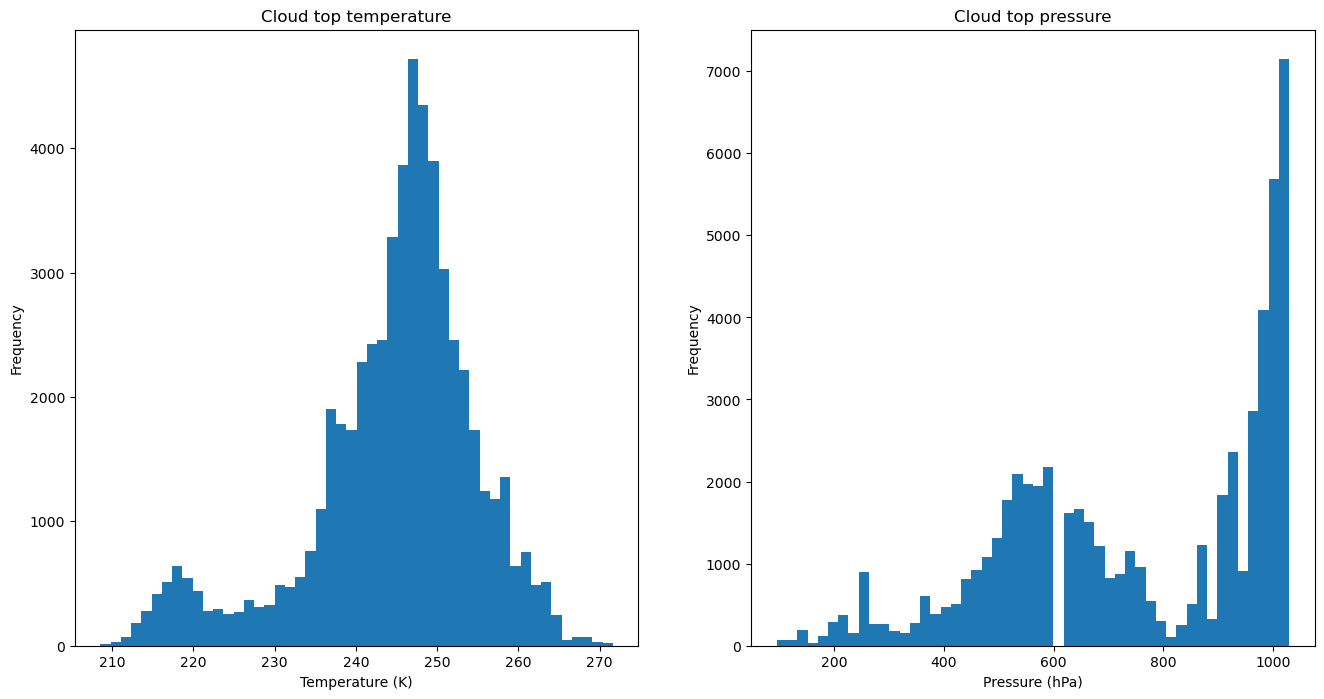

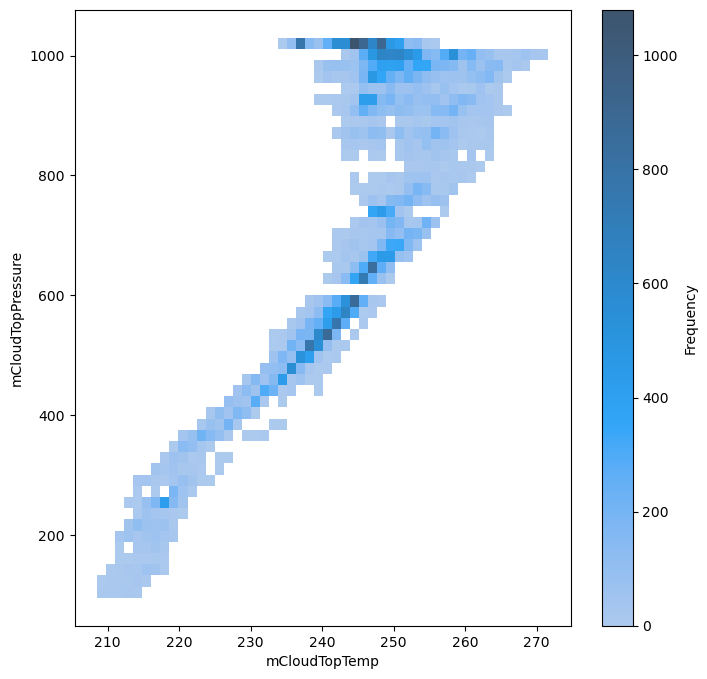

In [5]:
from pyhdf.SD import *
import os
import numpy as np
import matplotlib.pyplot as plt

prepath = "./test_data/MODIS/2017/01/01"
filename = "MYD06_L2.A2017001.1530.061.2018029075939.hdf"
filepath = os.path.join(prepath, filename)
from get_feature_sets import get_modis_cloud_top_properties

df_cloud_top_properties = get_modis_cloud_top_properties(filepath)

display(df_cloud_top_properties.describe())

# plot cloud top temp and cloud top pressure in a histogram
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(df_cloud_top_properties.mCloudTopTemp.values.flatten(), bins=50)
ax[0].set_title("Cloud top temperature")
ax[0].set_xlabel("Temperature (K)")
ax[0].set_ylabel("Frequency")

ax[1].hist(df_cloud_top_properties.mCloudTopPressure.values.flatten(), bins=50)
ax[1].set_title("Cloud top pressure")
ax[1].set_xlabel("Pressure (hPa)")
ax[1].set_ylabel("Frequency")

import seaborn as sns

# using seaborn, plot a bi-variate histogram of cloud top temperature and cloud top pressure
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df_cloud_top_properties, x="mCloudTopTemp", y="mCloudTopPressure", bins=50, cbar=True, ax=ax, cbar_kws={"label": "Frequency"})


## Test on a week of collocated data and do histogram

100%|██████████| 95/95 [00:01<00:00, 80.00it/s]


mCloudTopTemp  mCloudTopPressure
pixel_id fileID                                         
64651    A2017034.1430     223.789995         330.000005
64921    A2017034.1430     223.789995         330.000005
65191    A2017034.1430     221.119995         315.000005
65461    A2017034.1430     223.649995         330.000005
65731    A2017034.1430     223.649995         330.000005

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

<Axes: xlabel='mCloudTopTemp', ylabel='mCloudTopPressure'>

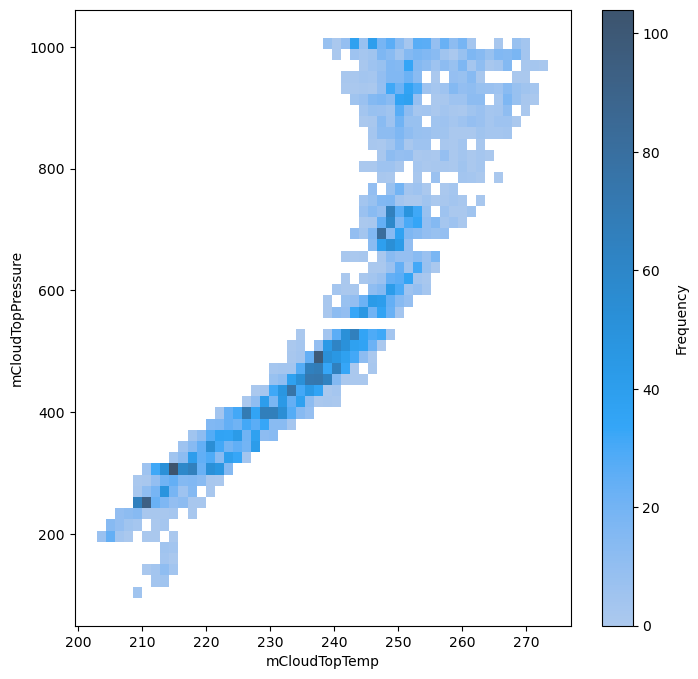

In [9]:
from get_feature_sets import get_feature_sets

cloud_top_props = get_feature_sets("modis_cloud_top_properties", "./test_data_first_feb_week/MODIS/", "./collocation_database/merged_collocations.csv")

display(cloud_top_props.head())

import seaborn as sns

# using seaborn, plot a bi-variate histogram of cloud top temperature and cloud top pressure
fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(cloud_top_props.reset_index(), x="mCloudTopTemp", y="mCloudTopPressure", bins=50, cbar=True, ax=ax, cbar_kws={"label": "Frequency"})